# Adversarial examples - Blind spot in representation spaces
### Author: Pietro Gori

As for all TP, answer all questions and fill the code where you see **XXXXXXXXX**

**Deadline**: please verify on the Moodle/Ecampus/web site the deadline

**Student**: Lucas Versini

In [1]:
import numpy as np
import random

# pytorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset, TensorDataset

# torchvision
from torchvision import models,transforms
import torchvision.datasets as Data

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
%matplotlib inline

import time

In this practical session, you will produce adversarial examples using two strategies to analyse the quality and smoothness of a representation space. We will use the Mnist dataset and a simple network (with 97% accuracy on test though...) so that you can train and test on your own laptop. Same conclusions can be drawn by using larger architectures and more complex datasets (You can try if you want).

Let's start with the first method. Please read first the article [1], in particular from Sectioon 4. 

`[1] Szegedy, Christian, Zaremba, Wojciech, Sutskever, Ilya, Bruna, Joan, Erhan, Dumitru, Goodfellow, Ian J.,
and Fergus, Rob. Intriguing properties of neural networks. ICLR, 2014`

We first check if you are using a computer with GPU, CUDA (Nvidia) or MPS (MacBook), or only CPU. 

In [2]:
print("Using torch", torch.__version__)

if torch.backends.mps.is_available():
    device = torch.device("mps")
    x = torch.ones(1, device=device)
    print(x)    
    print ("MPS (MacBook) device found.")
    print('Number of MPS cards: ', torch.mps.device_count())
    print('Total MPS memory {0:.2f} GB'.format(torch.mps.recommended_max_memory()/pow(10,9)))
elif torch.backends.cuda.is_built():
    device = torch.device("cuda")
    x = torch.ones(1, device=device)
    print(x) 
    print ("CUDA device found.")
    print('Number of GPU cards: ', torch.cuda.device_count(), '\nWhich card GPU?', torch.cuda.get_device_name(0))
    print('Total GPU memory {1:.2f} GB. Free GPU memory {0:.2f} GB'.format(torch.cuda.mem_get_info()[0]/pow(10,9),torch.cuda.mem_get_info()[1]/pow(10,9)))
else:
   device = torch.device("cpu")
   x = torch.ones(1, device=device)
   print(x) 
   print('No MPS or CUDA has been found. PyTorch will use CPU.')

Using torch 2.5.1
tensor([1.], device='cuda:0')
CUDA device found.
Number of GPU cards:  1 
Which card GPU? NVIDIA RTX A5000
Total GPU memory 25.40 GB. Free GPU memory 25.02 GB


Here we fix the different seeds to make your algorithm reproducible and we set the hyper-parameters for the classification model we are going to train. You can modify them if you want, but I suggest you keep them like that for now and modify them only AFTER having trained for a first time the model. 

In [3]:
# to make the results reproducible
np.random.seed(10)
torch.manual_seed(10)
torch.cuda.manual_seed(10)
torch.mps.manual_seed(10)
random.seed(10)


# Parameters for training model
weight_decay = 0
num_epochs = 10
batch_size=256 # adapted to the Google Colab GPU
learning_rate=0.001
loss_model=nn.CrossEntropyLoss()

We will use the MNIST dataset. Download it from torchvision.

In [4]:
mnist_train = Data.MNIST(root='data/',
                            train=True,
                            transform=transforms.ToTensor(),
                            download=True)

train_loader  = DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True)

mnist_test = Data.MNIST(root='data/',
                          train=False,
                          transform=transforms.ToTensor(),
                          download=True)

test_loader  = DataLoader(dataset=mnist_test,
                                          batch_size=10000,
                                          shuffle=False)

We analyse the data to check the number of samples and their size.

In [5]:
# Print information
print("There are ", len (mnist_train), "training images and ", len(mnist_test), "test images")
image_size=list(mnist_train[0][0].squeeze().shape)
print(f"Each image is of shape: {image_size}")  # [28, 28]


There are  60000 training images and  10000 test images
Each image is of shape: [28, 28]


Here we code the model proposed in the article. 

**Question**: complete the code so that you can create *A simple fully connected network with one or more hidden layers and a Softmax classifier. We refer to this network as “FC”*. Please code it so that the input_size of the model (i.e. size of the input images), the number and size of hidden layers (e.g., [100,100]) and the output size (i.e., number of possible classes) are parameters of the model. 

In [6]:
class FullyConnectedNet(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, dropout = 0.):
        super(FullyConnectedNet, self).__init__()

        # input layer
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size

        # hidden layers
        layers = []
        layers.append(nn.Linear(input_size, hidden_sizes[0]))
        layers.append(nn.ReLU())
        if dropout > 0:
            layers.append(nn.Dropout(p = dropout))

        for i in range(1, len(hidden_sizes)):
            layers.append(nn.Linear(hidden_sizes[i - 1], hidden_sizes[i]))
            layers.append(nn.ReLU())
            if dropout > 0:
                layers.append(nn.Dropout(p = dropout))
                
        layers.append(nn.Linear(hidden_sizes[-1], self.output_size))
        # layers.append(nn.Softmax(dim = 1)) # See the remark below

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, self.input_size)
        return self.model(x)

<span style="color:red">Remark:</span> When using the Cross Entropy loss `nn.CrossEntropyLoss`, it is recommended *not* to use a Softmax in our model. Indeed, `nn.CrossEntropyLoss` is already a combination of `nn.LogSoftmax()` and `nn.NLLLoss()`; see [here](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss), where it is said "Note that this case is equivalent to applying LogSoftmax on an input, followed by NLLLoss.". Of course, if we want to have a look at the probabilities predicted by the model, then we can do so by using Softmax; but to train the model, this should not be done.

So in the above code, I did not put Softmax; however I commented the line, to show that adding it is really easy.

Moreover, when using Softmax the test accuracy is about 96%, whereas it is about 97% when we do not use it.

**Question**: Create one of the model proposed in the article.

In [7]:
input_size = 28 * 28
hidden_sizes = [100, 100]
output_size = 10

# Model
model = FullyConnectedNet(input_size, hidden_sizes, output_size, dropout = 0.2).to(device)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Print the model
print("model:", model)

model: FullyConnectedNet(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=100, out_features=100, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=100, out_features=10, bias=True)
  )
)


Here we code the training procedure, as commonly done with Pytorch. Please note that we use the Adam optimizer.

In [8]:
def training(model, train_loader, optimizer, num_epochs, loss_model, verbose = True):
  for epoch in range(num_epochs):
    model.train()
    for i, (images, labels) in enumerate(train_loader):

        # Put images to GPU
        X = images.to(device)
        Y = labels.to(device)

        # Forward pass
        outputs = model(X)
        loss = loss_model(outputs, Y)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % 100 == 0 and verbose:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

And we evaluate it.

In [9]:
def evaluation(model, test_loader):
  model.eval()

  correct = 0
  total = 0

  for images, labels in test_loader:

      X  = images.to(device)
      Y  = labels.to(device)

      outputs = model(X) # array of size [num test images, num classes]

      predicted_class = torch.argmax(outputs.data, dim=1) # faster

      total += len(Y)
      correct += (predicted_class == Y).sum()

  print('Accuracy of test images: %f %%' % (100 * float(correct) / total))

In [10]:
# Training loop for model
training(model, train_loader, optimizer, 10, loss_model)

# Evaluation of model
evaluation(model, test_loader)

Epoch [1/10], Step [100/235], Loss: 0.5027
Epoch [1/10], Step [200/235], Loss: 0.3202
Epoch [2/10], Step [100/235], Loss: 0.2744
Epoch [2/10], Step [200/235], Loss: 0.2270
Epoch [3/10], Step [100/235], Loss: 0.2059
Epoch [3/10], Step [200/235], Loss: 0.2420
Epoch [4/10], Step [100/235], Loss: 0.1103
Epoch [4/10], Step [200/235], Loss: 0.1968
Epoch [5/10], Step [100/235], Loss: 0.1412
Epoch [5/10], Step [200/235], Loss: 0.1597
Epoch [6/10], Step [100/235], Loss: 0.0668
Epoch [6/10], Step [200/235], Loss: 0.1116
Epoch [7/10], Step [100/235], Loss: 0.1022
Epoch [7/10], Step [200/235], Loss: 0.1274
Epoch [8/10], Step [100/235], Loss: 0.0954
Epoch [8/10], Step [200/235], Loss: 0.0870
Epoch [9/10], Step [100/235], Loss: 0.0736
Epoch [9/10], Step [200/235], Loss: 0.0155
Epoch [10/10], Step [100/235], Loss: 0.0453
Epoch [10/10], Step [200/235], Loss: 0.0894
Accuracy of test images: 97.660000 %


**Question**: Is the performance good ? Test different architectures (number and size of hidden layers). You can also try different hyper-parameters (weight decay, number of epochs, etc.). Use the "Occam's razor principle" to choose and justify your final model. 

<ins> **Answer:** </ins>

We got 97.66 % accuracy.

First, we look at several architectures (all other hyperparameters being equal):

Layers | Test accuracy | Number of parameters
--- | --- | ---
784, 100, 10 | 96.06 % | 79,510
784, 100, 100, 10 | 96.87 % | 89,610
784, 200, 100, 10 | 97.46 % | 178,110
784, 200, 200, 10 | 97.49 % | 199,210
784, 200, 200, 100, 10 | 97.50 % | 218,310

Therefore, increasing the number of neurons leads to a higher test accuracy, but also to a higher number of parameters.
There is a bit of a difference in accuracy between the architecture [784, 100, 100, 10] and the architecture [784, 200, 100, 10] (+ 0.59%), but also a gap in the number of parameters (almost doubled).

So to remain efficient while having good results, we will keep the architecture [784, 100, 100, 10].

Now, for this given architecture, we look at the impact of the number of epochs:

Epochs | Test accuracy | Time to train and evaluate
--- | --- | ---
5 | 96.87 % | 22 s
10 | 97.66 % | 45 s
15 | 97.68 % | 67 s
20 | 97.90 % | 89 s

Once again, to get good results while keeping a reasonable accuracy, we will use 10 epochs: we get more than 97 % accuracy, under a minute.

Finally, we study the impact of some other hyperparameters:

Weight decay | Learning rate | Dropout | Test accuracy
--- | --- | --- | ---
0 | $10^{-3}$ | 0 | 97.47 %
0 | $10^{-3}$ | 0.2 | 97.66 %
0 | $5 \times 10^{-3}$ | 0 | 97.12 %
0 | $5 \times 10^{-3}$ | 0.2 | 97.54 %
$10^{-4}$ | $10^{-3}$ | 0 | 97.56 %
$10^{-4}$ | $10^{-3}$ | 0.2 | 97.46 %
$10^{-4}$ | $5 \times 10^{-3}$ | 0 | 97.10 %
$10^{-4}$ | $5 \times 10^{-3}$ | 0.2 | 97.32 %

The best result is achieved for a learning rate of $10^{-3}$, no weight decay, and a dropout of $20%$.

Since dropout actually tends to avoid the model from overfitting, it seems reasonable to use this model.

**Conclusion**: we use a model with architecture [784, 100, 100, 10], trained for 10 epochs with no weight decay, a learning rate of $10^{-3}$ and a dropout of 20%.

Here, you will code the method proposed in Sec. 4.1 of [1]. I copy/paste it here:

We denote by $f : R^m \rightarrow {1 . . . k}$ a classifier mapping image pixel value vectors to a discrete label set. We also assume that $f$ has an associated continuous loss function denoted by $\text{loss}_f : R^m × {1 . . . k} \rightarrow R^+$. For a given $x \in R^m$ image and target label $l \in {1 . . . k}$, we aim to solve the following box-constrained optimization problem:

• Minimize $||r||_2$ subject to:
1. $f(x + r) = l$
2. $x + r \in [0, 1]^m$


The minimizer $r$ might not be unique, but we denote one such $x + r$ for an arbitrarily chosen minimizer by $D(x, l)$. Informally, $x + r$ is the closest image to $x$ classified as $l$ by $f$. Obviously, $D(x, f(x)) = f(x)$, so this task is non-trivial only if $f(x) \neq l$. In general, the exact computation
of $D(x, l)$ is a hard problem, so we approximate it by using a box-constrained L-BFGS. Concretely, we find an approximation of $D(x, l)$ by performing line-search to find the minimum $c > 0$ for which the minimizer $r$ of the following problem satisfies $f(x + r) = l$.

• Minimize $c|r| + \text{loss}_f (x + r, l)$ subject to $x + r \in [0, 1]^m$

This penalty function method would yield the exact solution for $D(X, l)$ in the case of convex losses, however neural networks are non-convex in general, so we end up with an approximation in this case.

We start by setting the hyper-parameters of the L-BFGS method. Keep them like that for now. You will come back later to change them.

In [11]:
# Parameters adversarial example
index=666 # index test image to use

max_iter_search=300
initial_c = 0.0001  # Initial value of c
max_c = 0.01  # Upper limit for c
mult_c = 1.03 # Multiplicative update of c at each iter c *= mult_c

epsilon_LBFGS = 1e-6  # Small value for line search stopping criterion
max_iter_LBFGS = 100  # Maximum iterations for L-BFGS
lr_LBFGS = 0.1  # Learning rate for L-BFGS

We can plot the chosen image

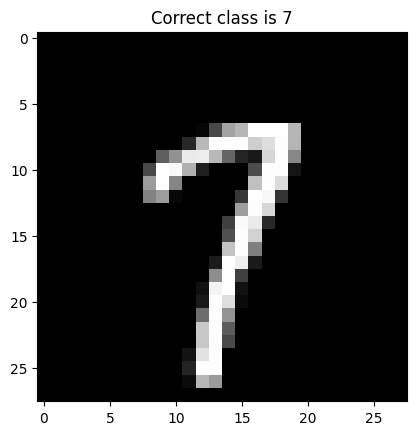

In [12]:
testI, testY = mnist_test.__getitem__(index)
fig = plt.imshow(testI.squeeze(), interpolation='nearest', cmap=plt.cm.gray)
plt.title(f"Correct class is {testY}")
plt.show()

I have written a code to plot the original image $x$, the modified image $x+r$ and the residual added $r$.

In [13]:
def plot_results(X, r, Xr, Y, l, fail=True):

    
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25, 7))
    im1 = axes[0].imshow(X.squeeze().cpu().detach().numpy(), interpolation='nearest', cmap=plt.cm.gray)
    axes[0].set_title(f"Original Image. Correct class is {Y}",fontsize=22)

    im3=axes[2].imshow(r.squeeze().cpu().detach().numpy(), interpolation='nearest', cmap=plt.cm.gray)
    axes[2].set_title(f"Residual added",fontsize=22)

    if fail:
        im2=axes[1].imshow(Xr.squeeze().cpu().detach().numpy(), interpolation='nearest', cmap=plt.cm.gray)    
        axes[1].set_title(f"Modified Image, FAILED to predict class {l.item()}",fontsize=22)
    else:
        im2=axes[1].imshow(Xr.squeeze().cpu().detach().numpy(), interpolation='nearest', cmap=plt.cm.gray)    
        axes[1].set_title(f"Modified Image, PREDICTED class {l.item()}",fontsize=22)

    # Add a single colorbar for all subplots
    cbar = fig.colorbar(im3, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
    cbar.set_label('Intensity (0 to 1)')

    # Show the plots
    plt.show()

Here we will code the proposed method. Complete the code where you see `XXXXXXX`.

Please be advised that the `torch.optim.LBFGS` optimizer is designed to work with a `closure` for computing the loss and gradients multiple times during optimization, which is essential for second-order methods.

The closure is a callable function passed to LBFGS that recomputes the loss and its gradients multiple times during a single optimization step.
To work correctly, we need to call `optimizer.zero_grad()` to clear old gradients before calculating new ones.

Please note that SGD or Adam don't require a closure because they update the parameters based on the current gradient in a single step.

More info here: https://pytorch.org/docs/stable/optim.html

**Answer**: I put everything in a function to avoid copy-pasting for the next experiments.

The true class is 7, the new class will be 8


Found c = 0.000100 satisfying f(x + r) = l
Optimization succeeded with c = 0.000100 in 0 iterations
Norm Perturbation |r|: 35.54383087158203


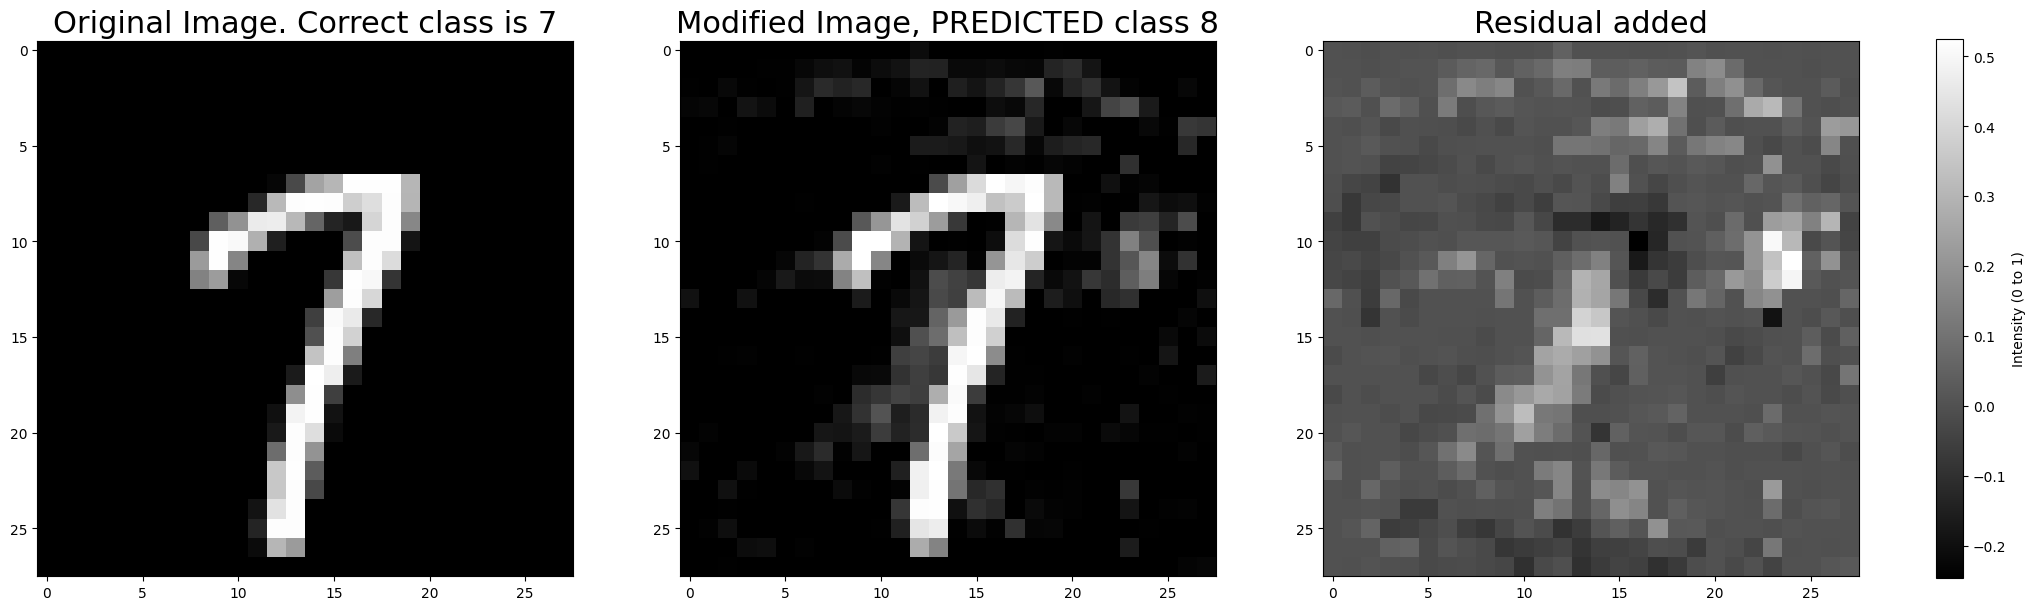

In [14]:
def adversarial(testI, testY, label, model, loss_model, device, verbose = True):
    testI = testI.to(device)

    r = torch.zeros_like(testI, requires_grad = True, device = device)  # Initialize r as zero
    l = torch.tensor([label]).to(device)  
    l = l.view(1) # to have a batch size equal to 1 and work with CrossEntropy loss
    if verbose:
        print(f"The true class is {testY}, the new class will be {l[0]}")

    # Define the loss function
    def objective(c, r, x, l):
        # Compute the loss function
        loss = loss_model(model(torch.clamp(x + r, 0, 1)), l) + c * torch.norm(r, p = 1)
        return loss

    # Line search to find the minimum c > 0
    c = initial_c
    iter = 0
    while (c <= max_c) and (iter <= max_iter_search):    
        # Define the optimizer (Box-Constrained L-BFGS)
        optimizerLBFGS = optim.LBFGS([r], lr = lr_LBFGS, max_iter = max_iter_LBFGS, line_search_fn = 'strong_wolfe')

        def closure():
          optimizerLBFGS.zero_grad()
          loss = objective(c, r, testI, l)
          loss.backward()
          return loss

        # Perform optimization
        optimizerLBFGS.step(closure)

        # Evaluate the condition f(x + r) = l
        with torch.no_grad():
            x_r = torch.clamp(testI + r, 0, 1)  # Ensure x + r ∈ [0, 1]^m
            pred = model(x_r)
            predicted_label = torch.argmax(pred, dim=1)

        # Check if the condition f(x + r) = l is satisfied
        if predicted_label == l:
            if verbose:
                print(f"Found c = {c:.6f} satisfying f(x + r) = l")
            break

        # If not satisfied, increase c
        c *= mult_c
        iter=iter+1
    
    if (c > max_c) or (iter > max_iter_search):
        if verbose:
            print("Failed to find c satisfying f(x + r) = l within the maximum limit of c and max number of iter.")
        plot_results(testI, r, x_r, testY, l, fail=True)
    
    else:
        if verbose:
            print(f"Optimization succeeded with c = {c:.6f} in {iter} iterations")
            print(f"Norm Perturbation |r|: {torch.norm(r, p=1)}")
        plot_results(testI, r, x_r, testY, l, fail=False)
    
    return testI + r

_ = adversarial(testI, testY, 8, model, loss_model, device)

**QUESTION** Try with different images and different predicted classes (l), does the algorithm always converge ? You can test with different hyper-parameters for c. When it converges, are the images semantically similar to the original one ? Visually, would you say that they should belong to the original or new class ? What's the average distortion (norm of r) ?

In [15]:
# To get the index of the first image of each class

index_first_image = [-1] * 10
count = 0
idx = 0

while count < 10:
    testI, testY = mnist_test.__getitem__(idx)
    if index_first_image[testY] == -1:
        index_first_image[testY] = idx
        count += 1
    idx += 1

print(index_first_image)

[3, 2, 1, 18, 4, 8, 11, 0, 61, 7]


The true class is 0, the new class will be 8
Found c = 0.000100 satisfying f(x + r) = l
Optimization succeeded with c = 0.000100 in 0 iterations
Norm Perturbation |r|: 73.16468048095703


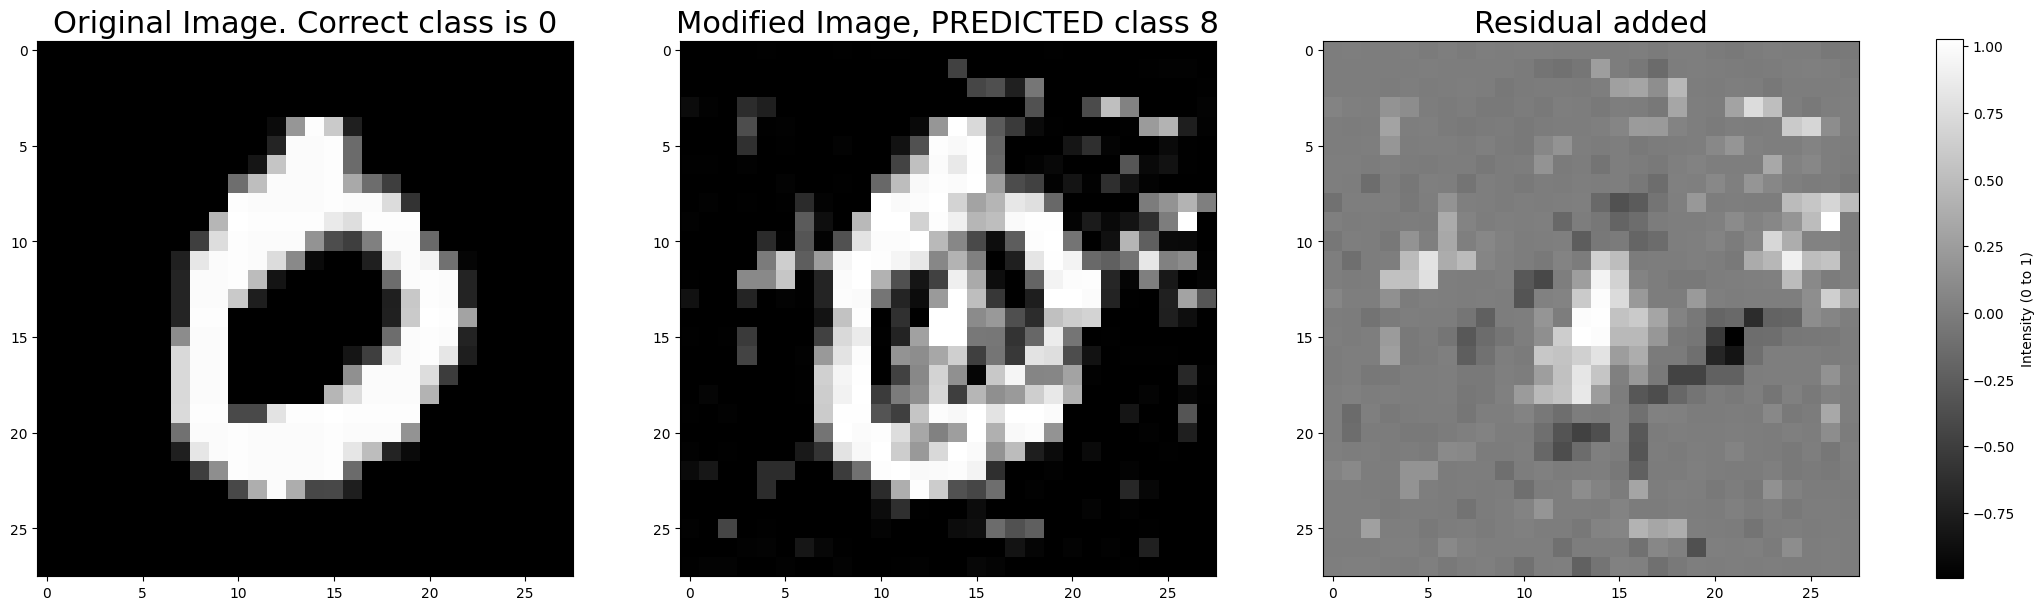

The true class is 1, the new class will be 8
Found c = 0.000100 satisfying f(x + r) = l
Optimization succeeded with c = 0.000100 in 0 iterations
Norm Perturbation |r|: 24.694229125976562


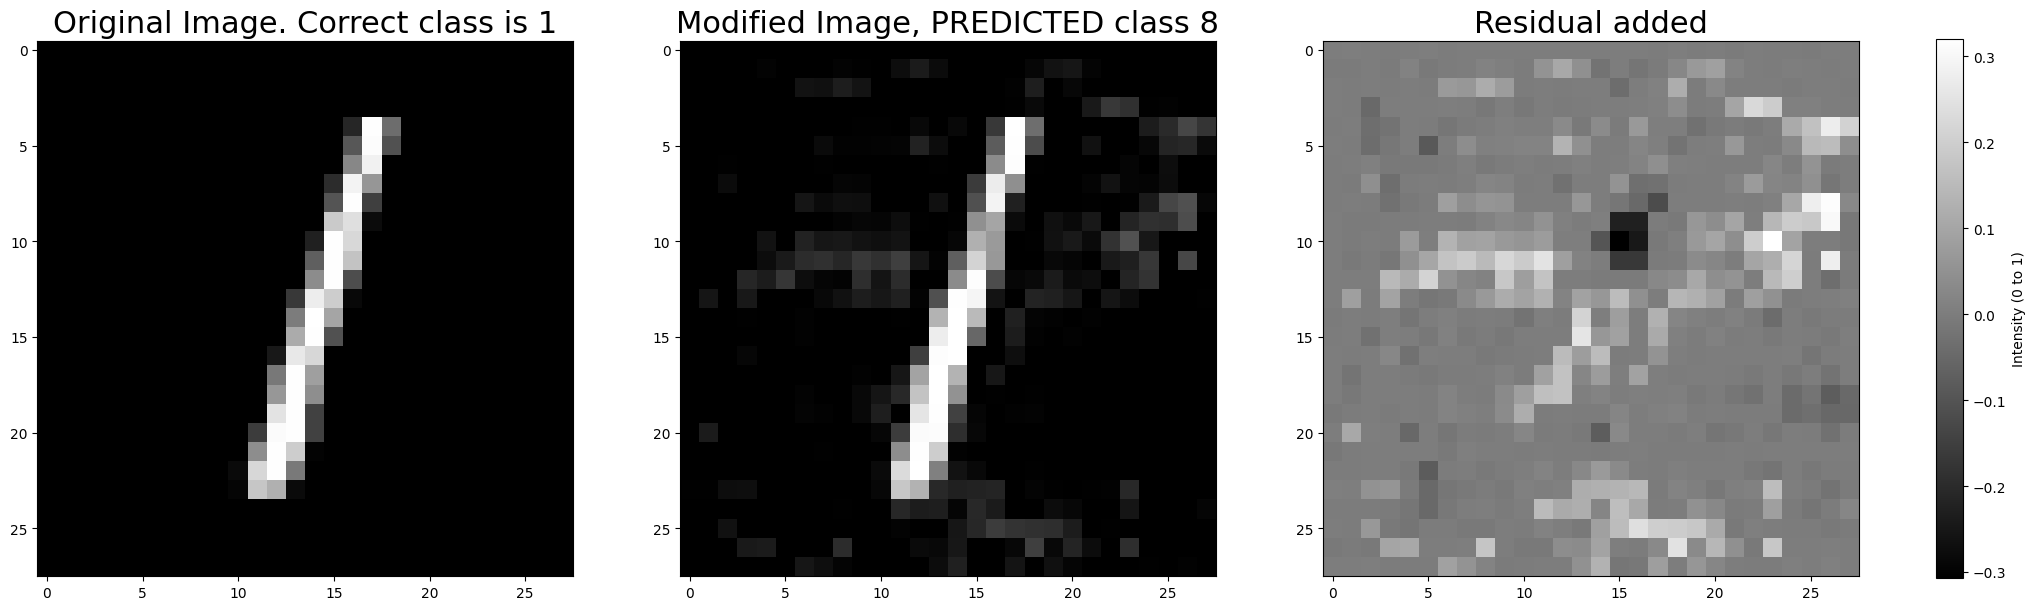

The true class is 2, the new class will be 8
Found c = 0.000100 satisfying f(x + r) = l
Optimization succeeded with c = 0.000100 in 0 iterations
Norm Perturbation |r|: 56.05081558227539


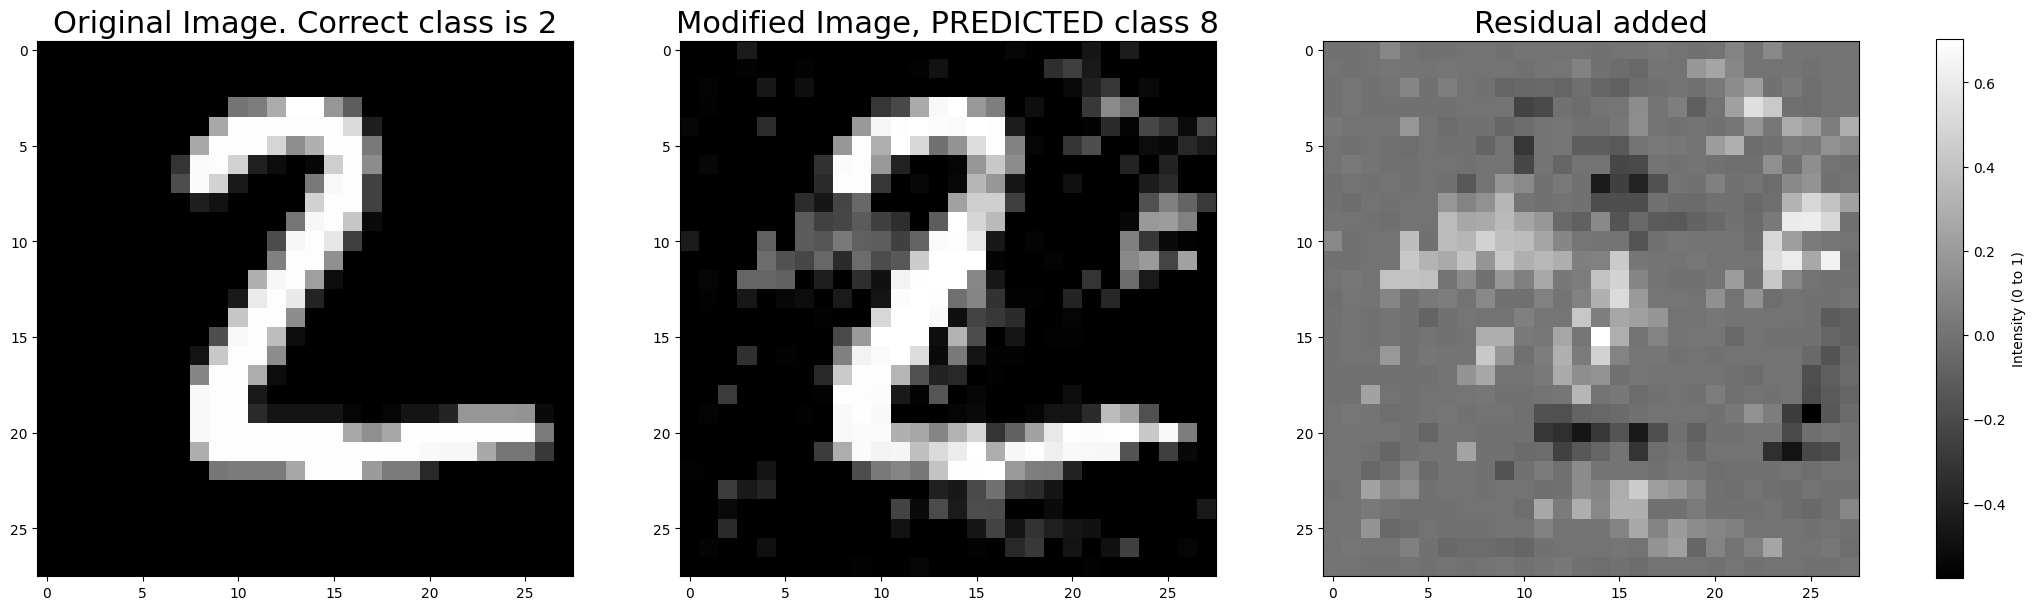

The true class is 3, the new class will be 8
Found c = 0.000100 satisfying f(x + r) = l
Optimization succeeded with c = 0.000100 in 0 iterations
Norm Perturbation |r|: 51.41770935058594


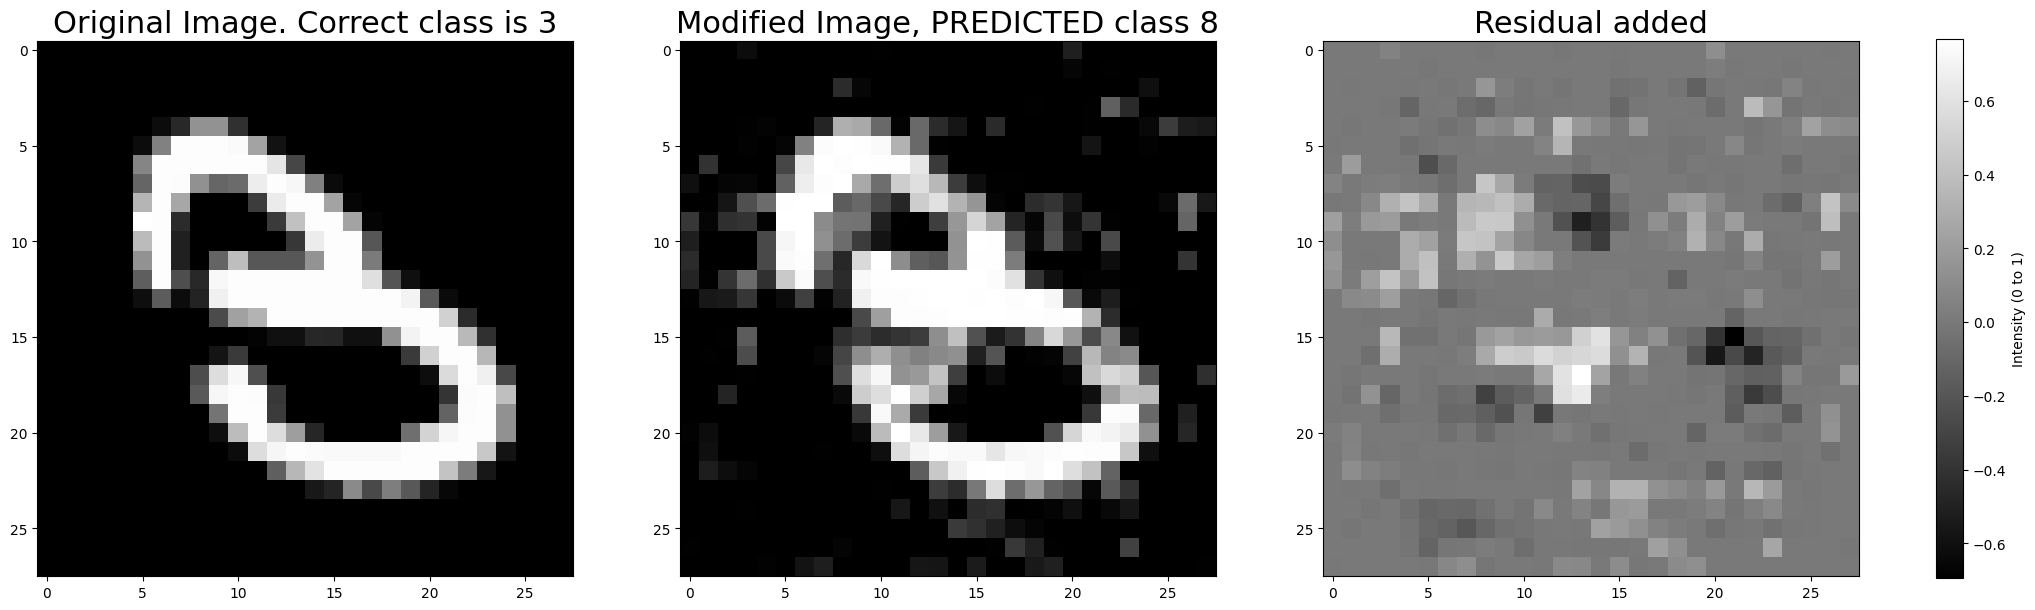

The true class is 4, the new class will be 8
Found c = 0.000100 satisfying f(x + r) = l
Optimization succeeded with c = 0.000100 in 0 iterations
Norm Perturbation |r|: 44.28989028930664


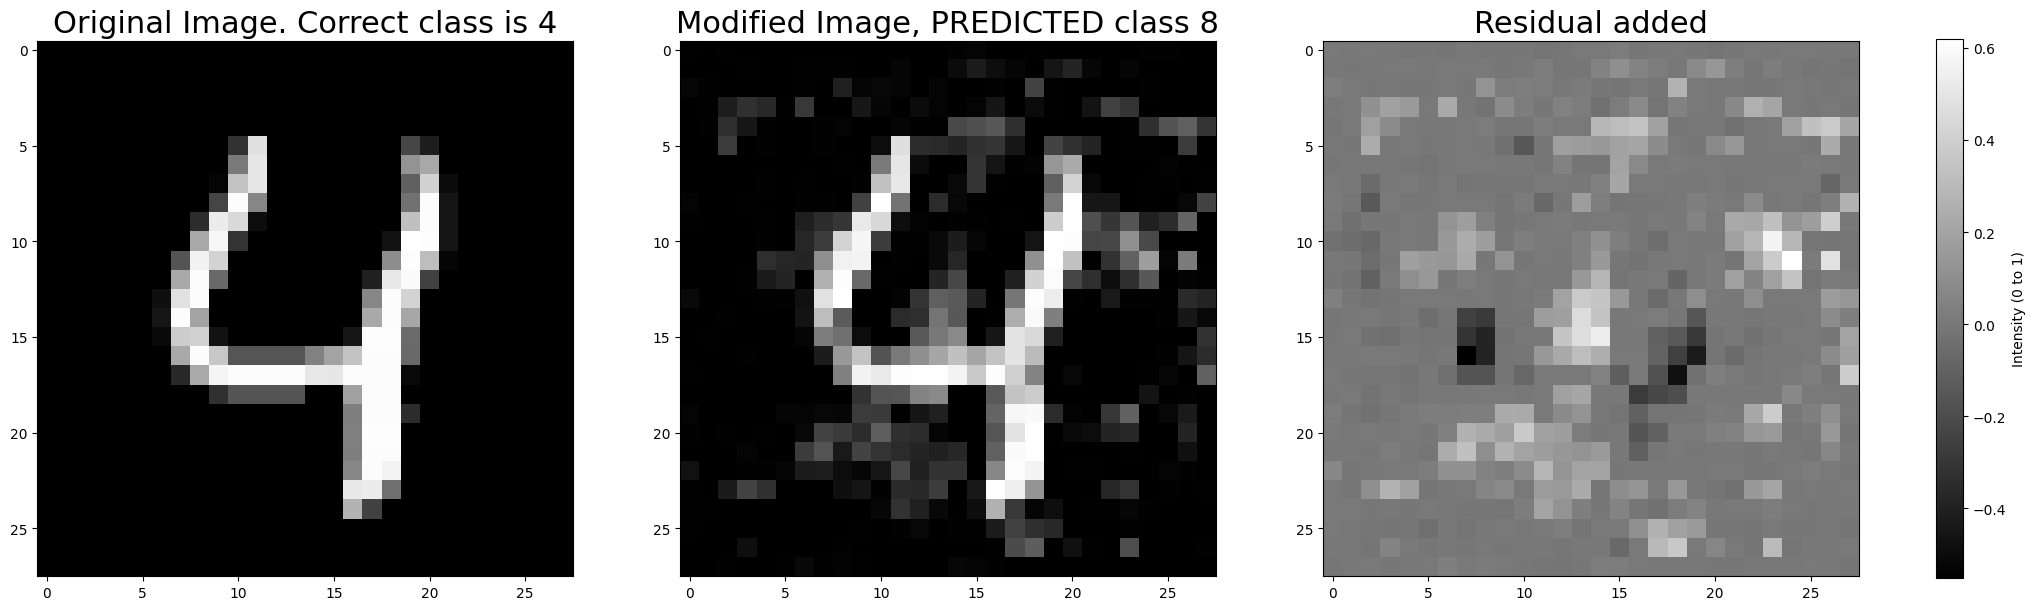

The true class is 5, the new class will be 8
Found c = 0.000100 satisfying f(x + r) = l
Optimization succeeded with c = 0.000100 in 0 iterations
Norm Perturbation |r|: 45.89786911010742


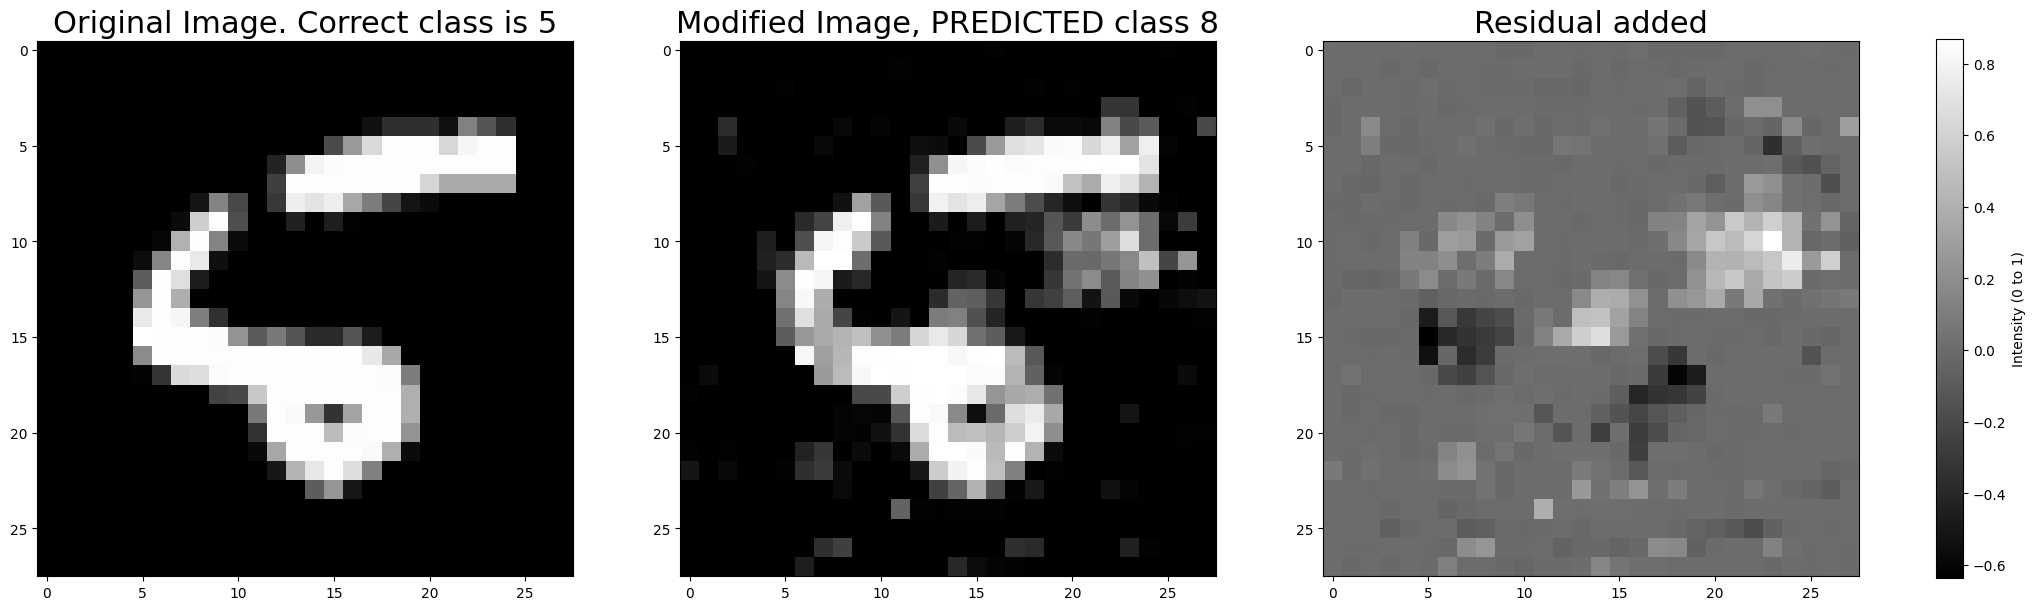

The true class is 6, the new class will be 8
Found c = 0.000100 satisfying f(x + r) = l
Optimization succeeded with c = 0.000100 in 0 iterations
Norm Perturbation |r|: 52.12757873535156


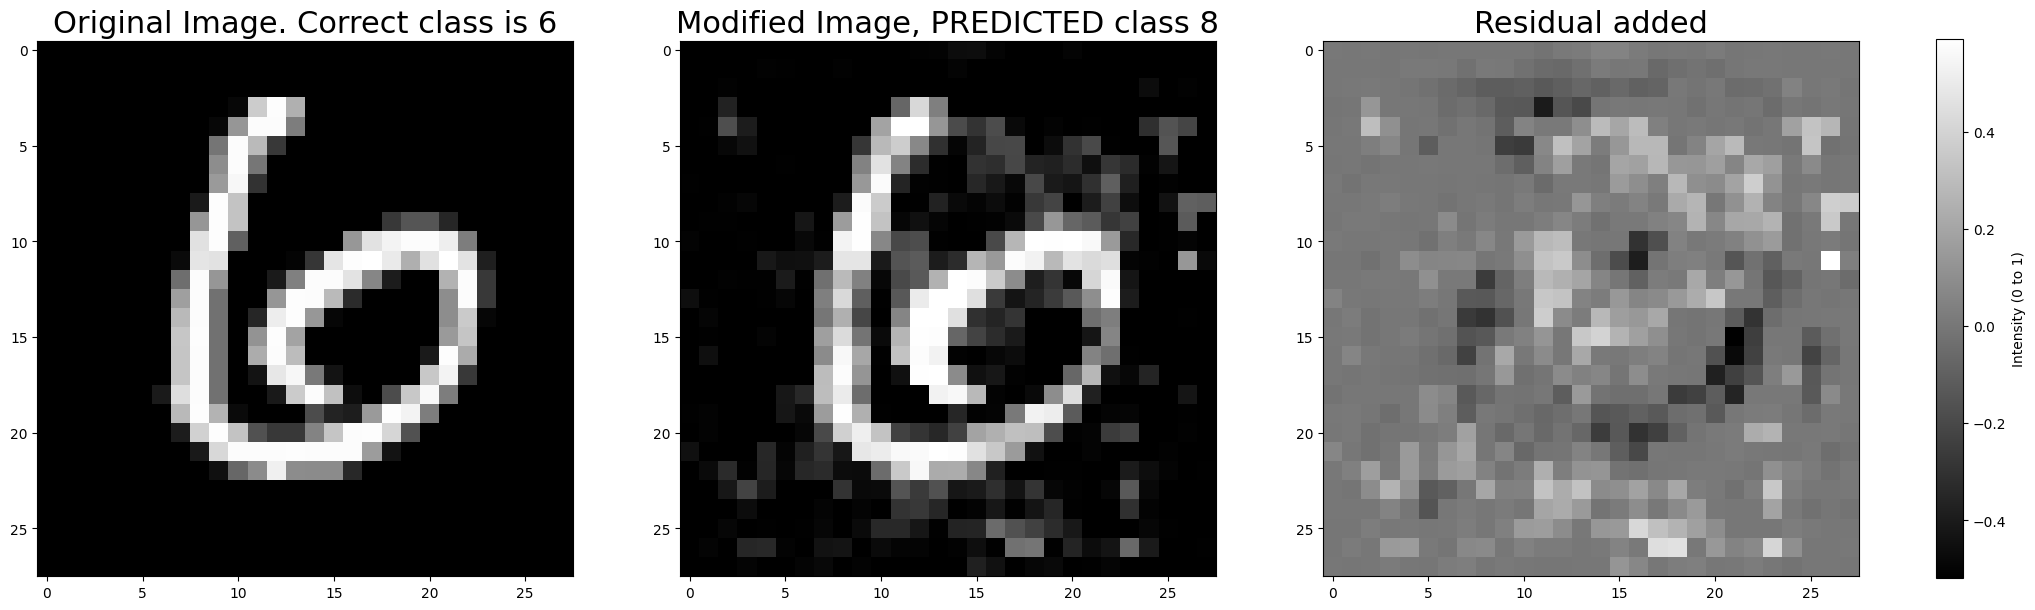

The true class is 7, the new class will be 8
Found c = 0.000100 satisfying f(x + r) = l
Optimization succeeded with c = 0.000100 in 0 iterations
Norm Perturbation |r|: 42.41914367675781


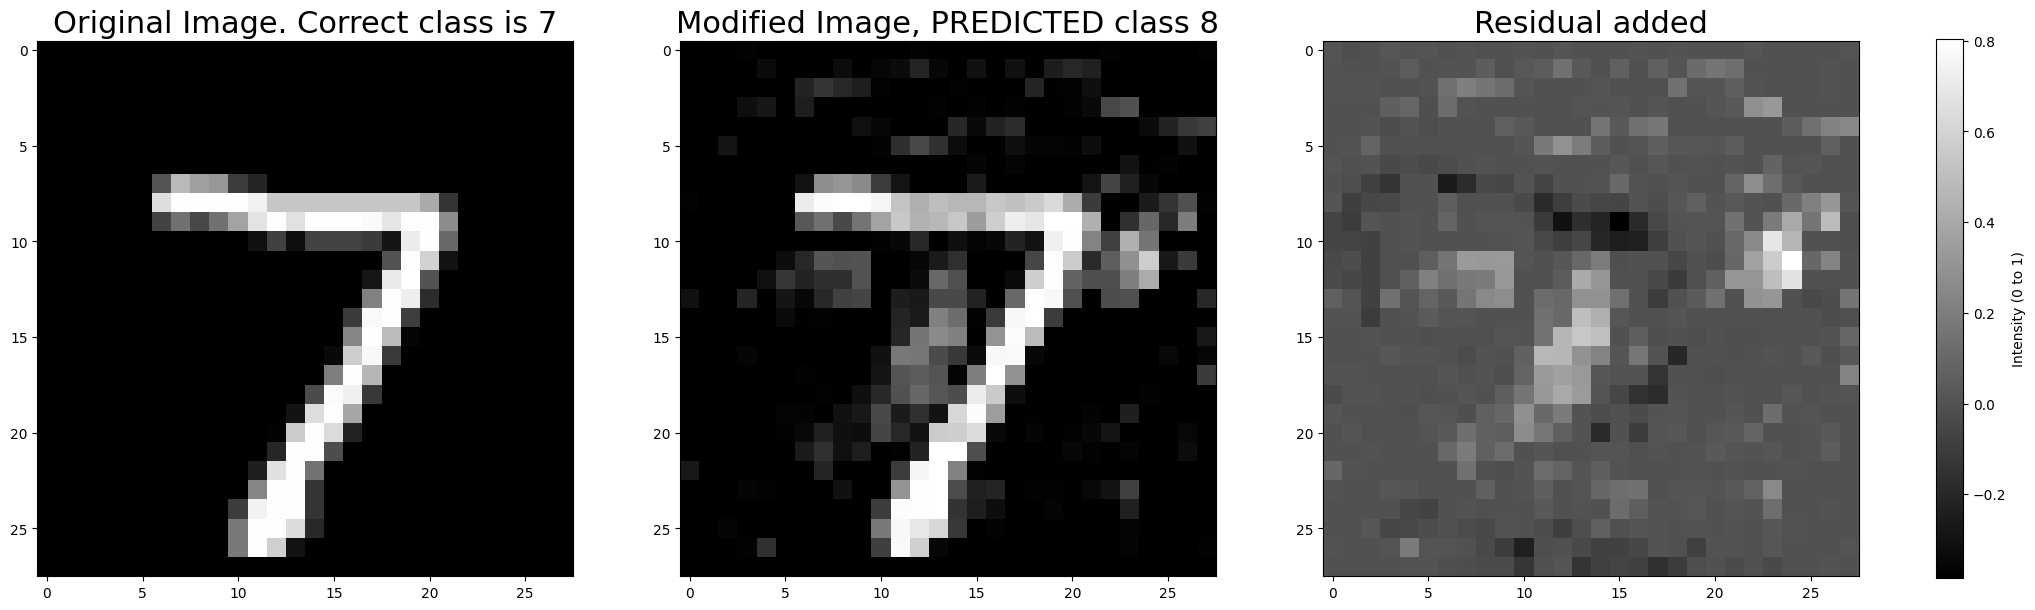

The true class is 8, the new class will be 9
Found c = 0.000100 satisfying f(x + r) = l
Optimization succeeded with c = 0.000100 in 0 iterations
Norm Perturbation |r|: 36.535682678222656


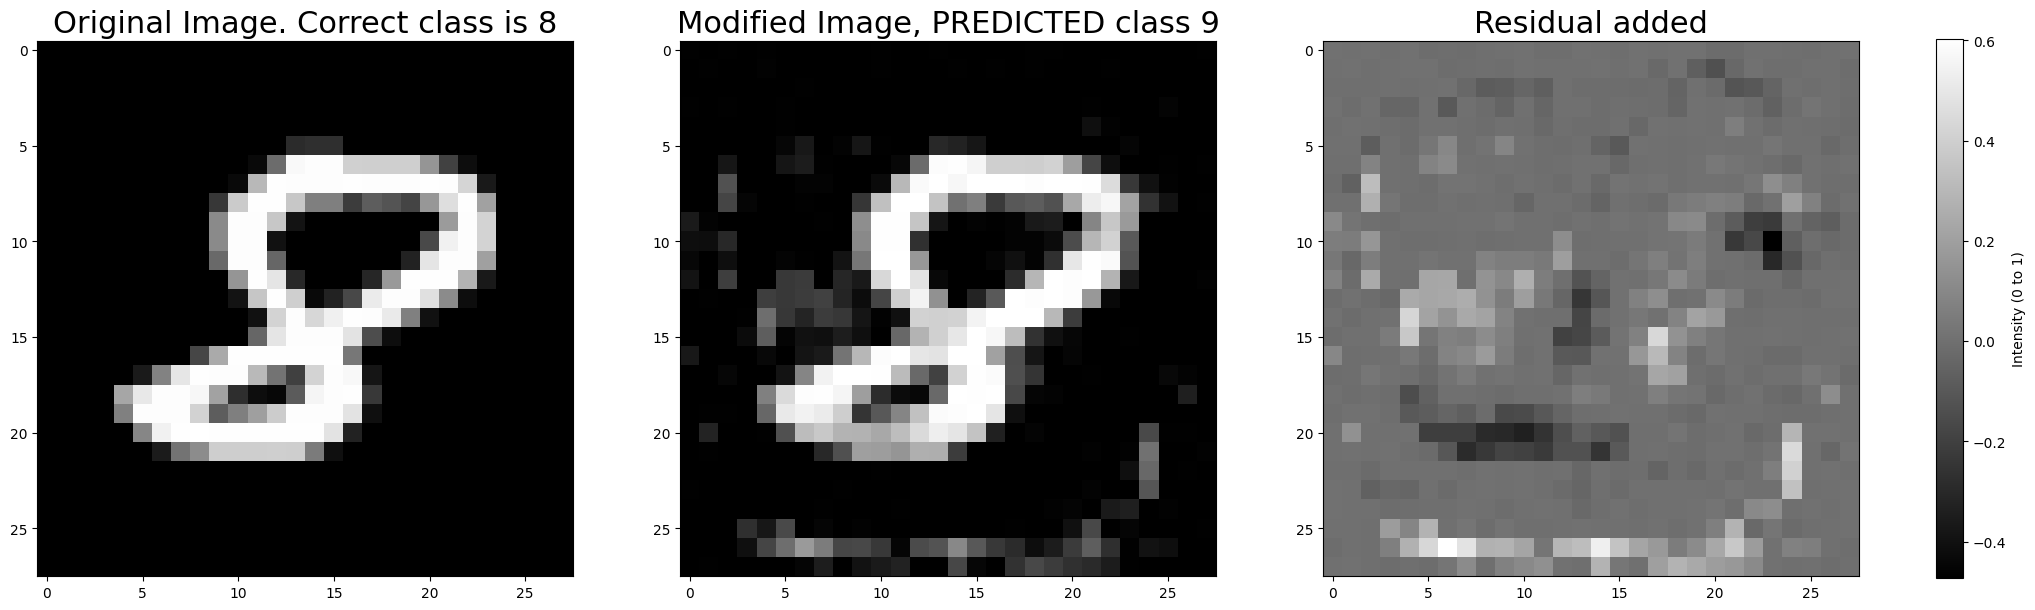

The true class is 9, the new class will be 8
Found c = 0.000100 satisfying f(x + r) = l
Optimization succeeded with c = 0.000100 in 0 iterations
Norm Perturbation |r|: 50.22823715209961


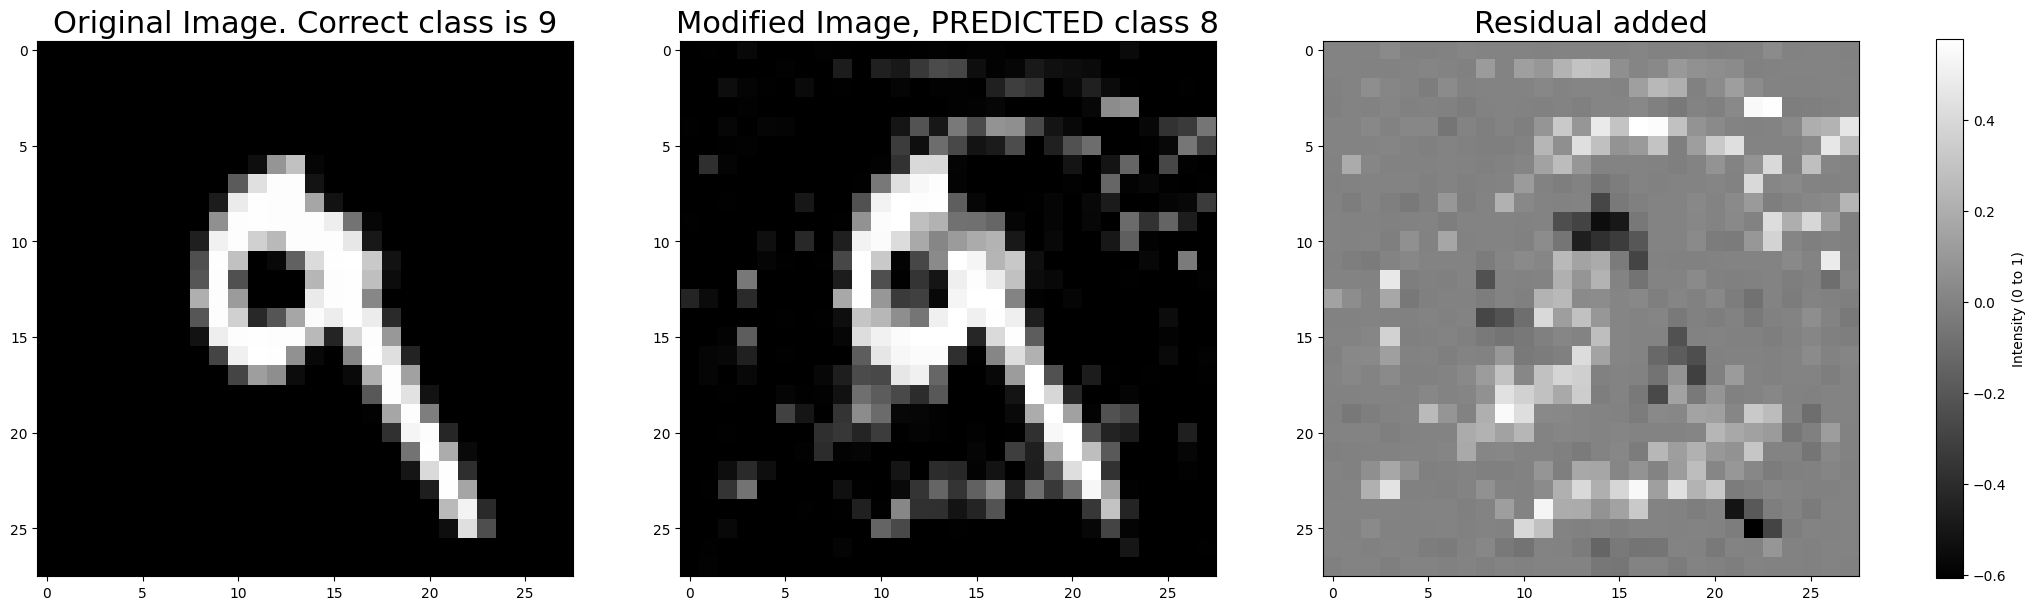

In [16]:
list_adversarial = []
label = 8

list_r = []

for index in index_first_image:
    testI, testY = mnist_test.__getitem__(index)
    label_ = label if testY != label else (label + 1) % 10 # If the image is of the class label, we choose the next class
    adv = adversarial(testI, testY, label_, model, loss_model, device, verbose = True)
    list_adversarial.append((adv, testY, label_))

**Answer**:

- The algorithm does not always converge. I tried to use a stopping criterion not only based on whether the predicted class is the one we want, but also whether the norm of the perturbation is small enough, but either my threshold was too large, and this criterion did not change anything, or it was too low, and it led to failure very often.

- On the above images, the average error is about $47.5$.

- Clearly the above images still look like the original ones, and would therefore be classified as such by a human being. However, we also see that they were altered. To get these results, I increased the initial value of $c$ to penalize large perturbations, to get images that visually look more like the initial image.

**Question** What if you try with different networks ? Test with al least another network (i.e., change hidden_sizes) and see if the previous conclusions are still confirmed. 

Furthermore, check the cross-network performance. This means:
- produce a set of adversarial instances for a given network (samples that are visually similar to the original class but recognised by the network as belonging to a different class)
- check if these adversarial examples are also wrongly classified by the other network

Which conclusions can you draw from these results ? Please comment on that.

**Answer**: We use a model with architecture [784, 200, 200, 200, 10], trained for 10 epochs with no weight decay, a learning rate of $10^{-3}$ and no dropout. This architecture is quite different from the previous one, which is precisely what we want.

In [17]:
model_2 = FullyConnectedNet(input_size, [200, 200, 200], output_size, dropout = 0.).to(device)
optimizer_2 = optim.Adam(model_2.parameters(), lr=learning_rate, weight_decay=weight_decay)

print("model 2:", model_2)

# Training loop for model 2
training(model_2, train_loader, optimizer_2, 10, loss_model)
# Evaluation of model 2
evaluation(model_2, test_loader)

model 2: FullyConnectedNet(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=200, out_features=200, bias=True)
    (5): ReLU()
    (6): Linear(in_features=200, out_features=10, bias=True)
  )
)
Epoch [1/10], Step [100/235], Loss: 0.2792
Epoch [1/10], Step [200/235], Loss: 0.1877
Epoch [2/10], Step [100/235], Loss: 0.1933
Epoch [2/10], Step [200/235], Loss: 0.1011
Epoch [3/10], Step [100/235], Loss: 0.0715
Epoch [3/10], Step [200/235], Loss: 0.1245
Epoch [4/10], Step [100/235], Loss: 0.1186
Epoch [4/10], Step [200/235], Loss: 0.0993
Epoch [5/10], Step [100/235], Loss: 0.1195
Epoch [5/10], Step [200/235], Loss: 0.1100
Epoch [6/10], Step [100/235], Loss: 0.0452
Epoch [6/10], Step [200/235], Loss: 0.1193
Epoch [7/10], Step [100/235], Loss: 0.0525
Epoch [7/10], Step [200/235], Loss: 0.0689
Epoch [8/10], Step [100/235], Loss: 0.0455
Epo

**Answer**: like before, we can create some adversarial images using this second model.

The true class is 0, the new class will be 8
Found c = 0.000100 satisfying f(x + r) = l
Optimization succeeded with c = 0.000100 in 0 iterations
Norm Perturbation |r|: 73.16468048095703


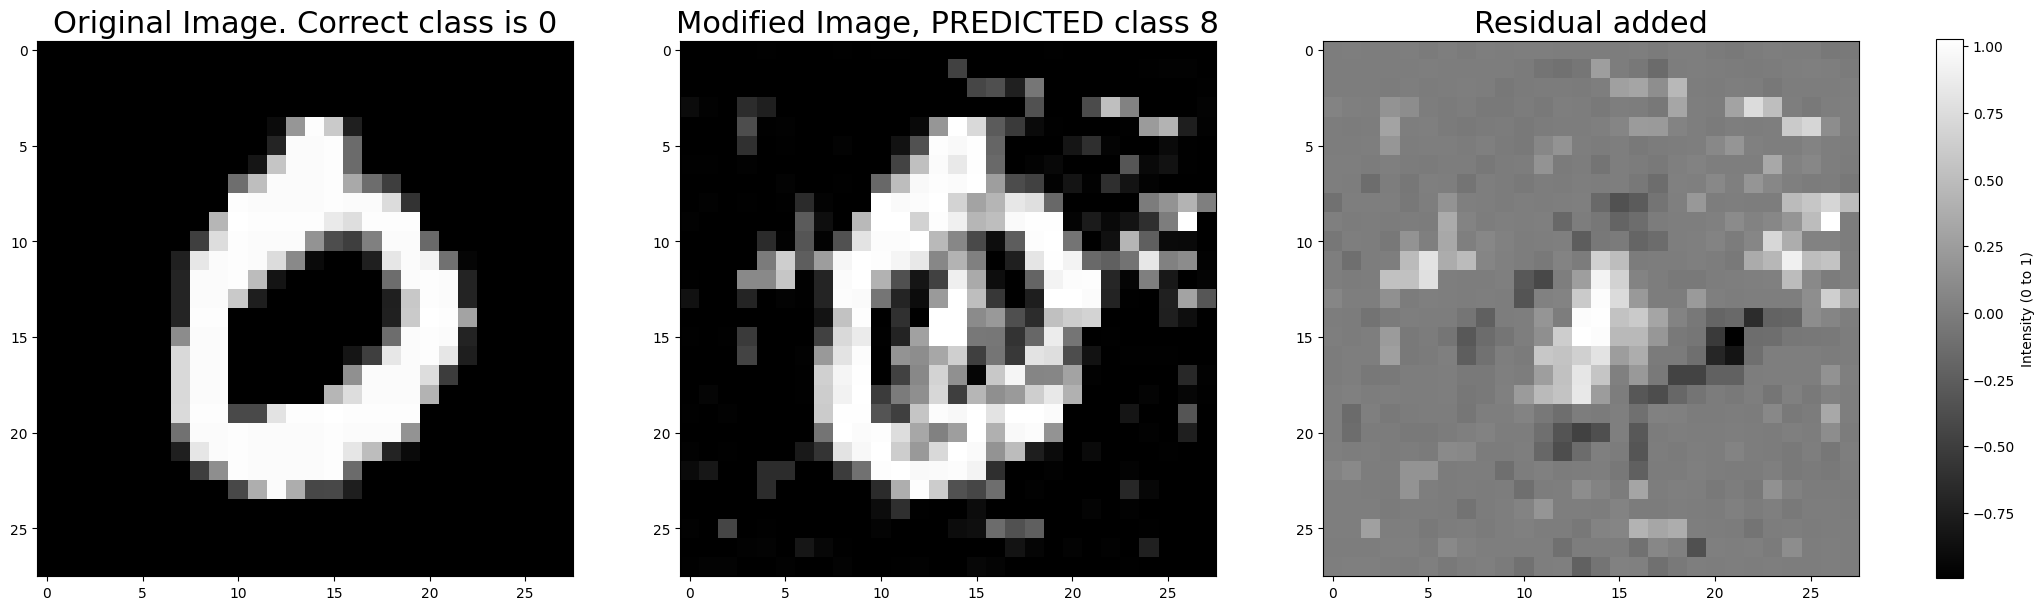

The true class is 1, the new class will be 8
Found c = 0.000100 satisfying f(x + r) = l
Optimization succeeded with c = 0.000100 in 0 iterations
Norm Perturbation |r|: 24.694229125976562


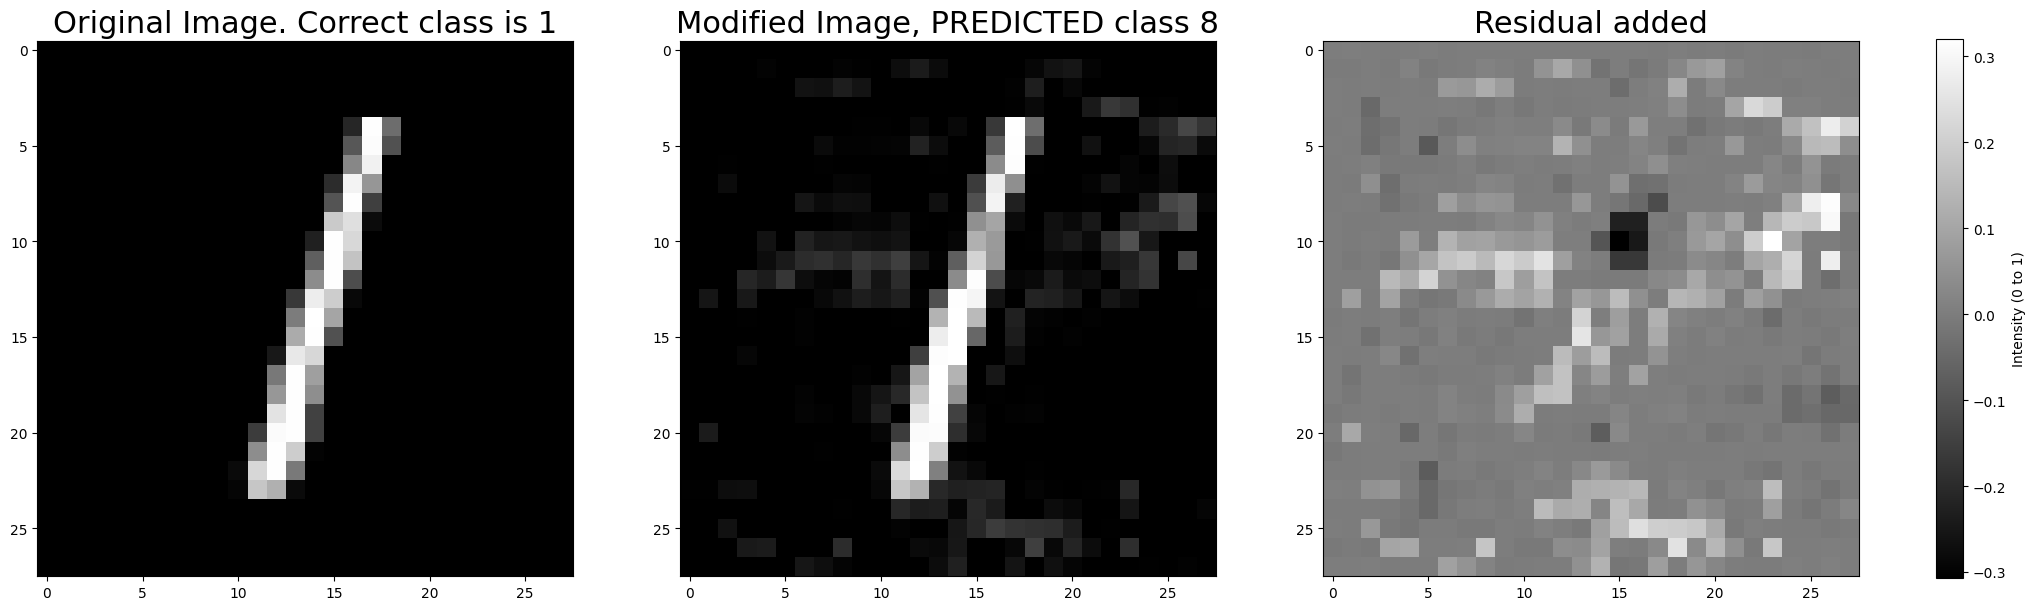

The true class is 2, the new class will be 8
Found c = 0.000100 satisfying f(x + r) = l
Optimization succeeded with c = 0.000100 in 0 iterations
Norm Perturbation |r|: 56.05081558227539


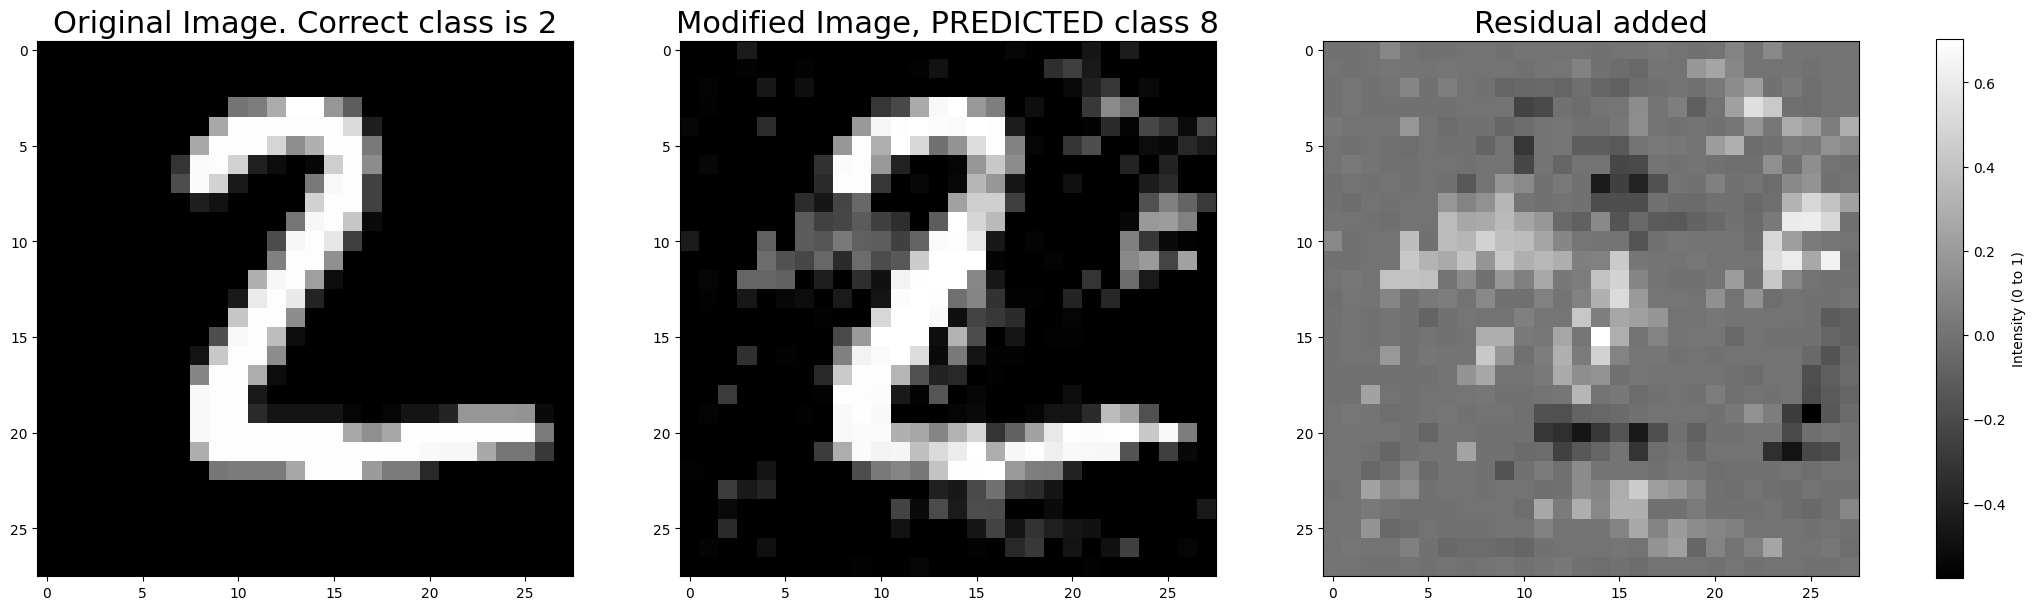

The true class is 3, the new class will be 8
Found c = 0.000100 satisfying f(x + r) = l
Optimization succeeded with c = 0.000100 in 0 iterations
Norm Perturbation |r|: 51.41770935058594


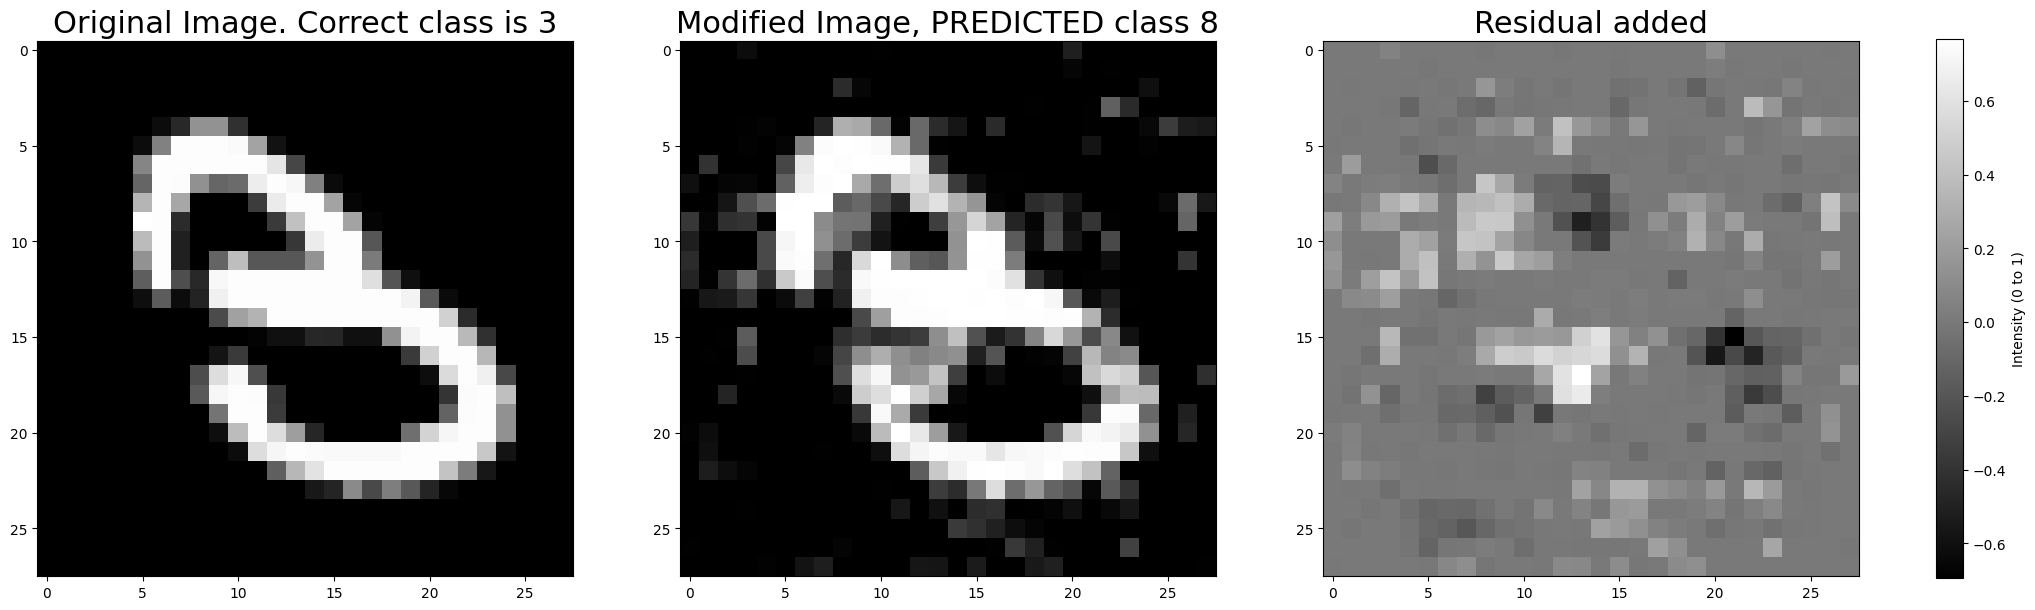

The true class is 4, the new class will be 8
Found c = 0.000100 satisfying f(x + r) = l
Optimization succeeded with c = 0.000100 in 0 iterations
Norm Perturbation |r|: 44.28989028930664


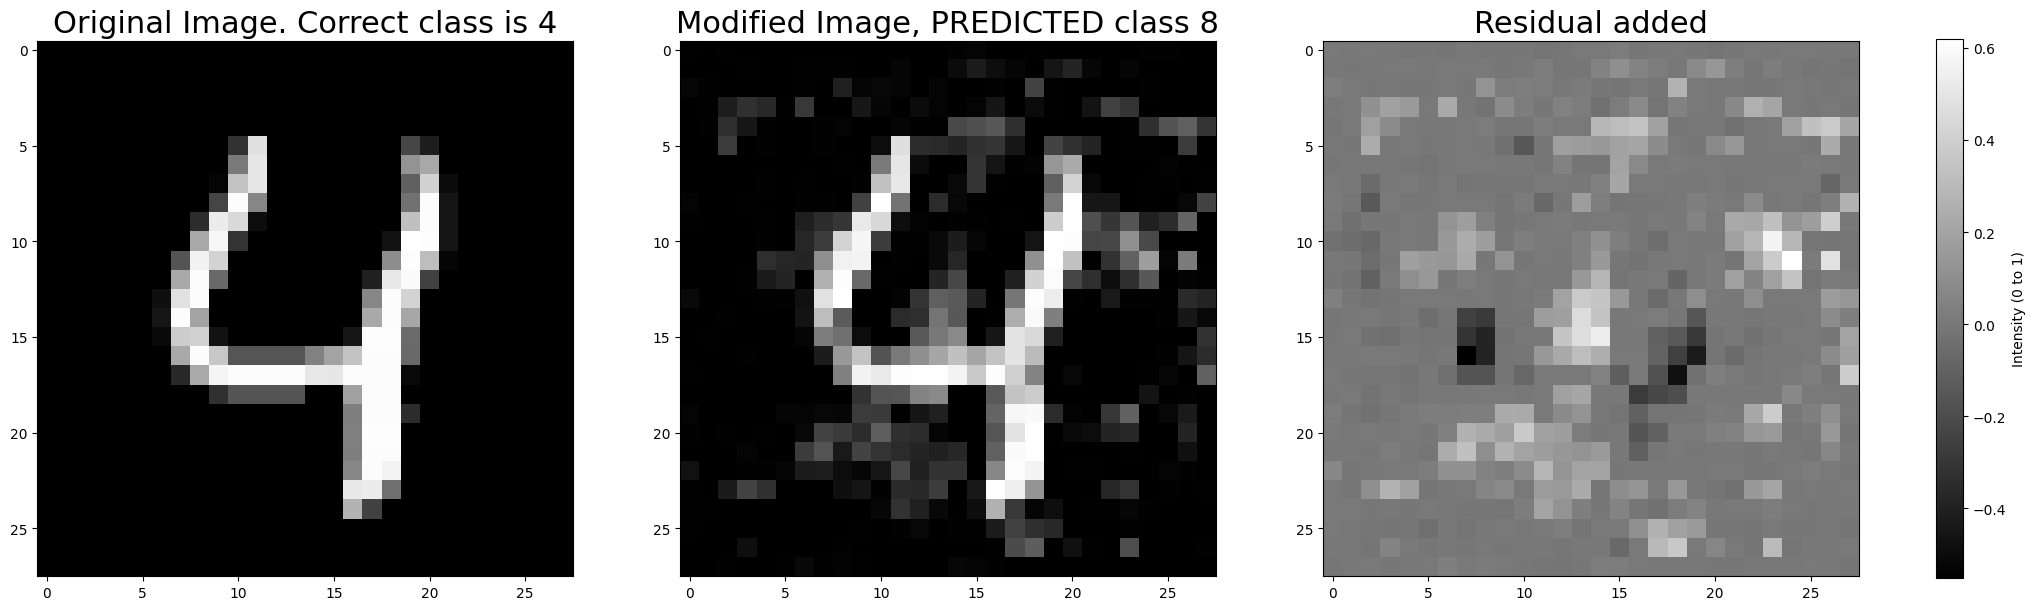

The true class is 5, the new class will be 8
Found c = 0.000100 satisfying f(x + r) = l
Optimization succeeded with c = 0.000100 in 0 iterations
Norm Perturbation |r|: 45.89786911010742


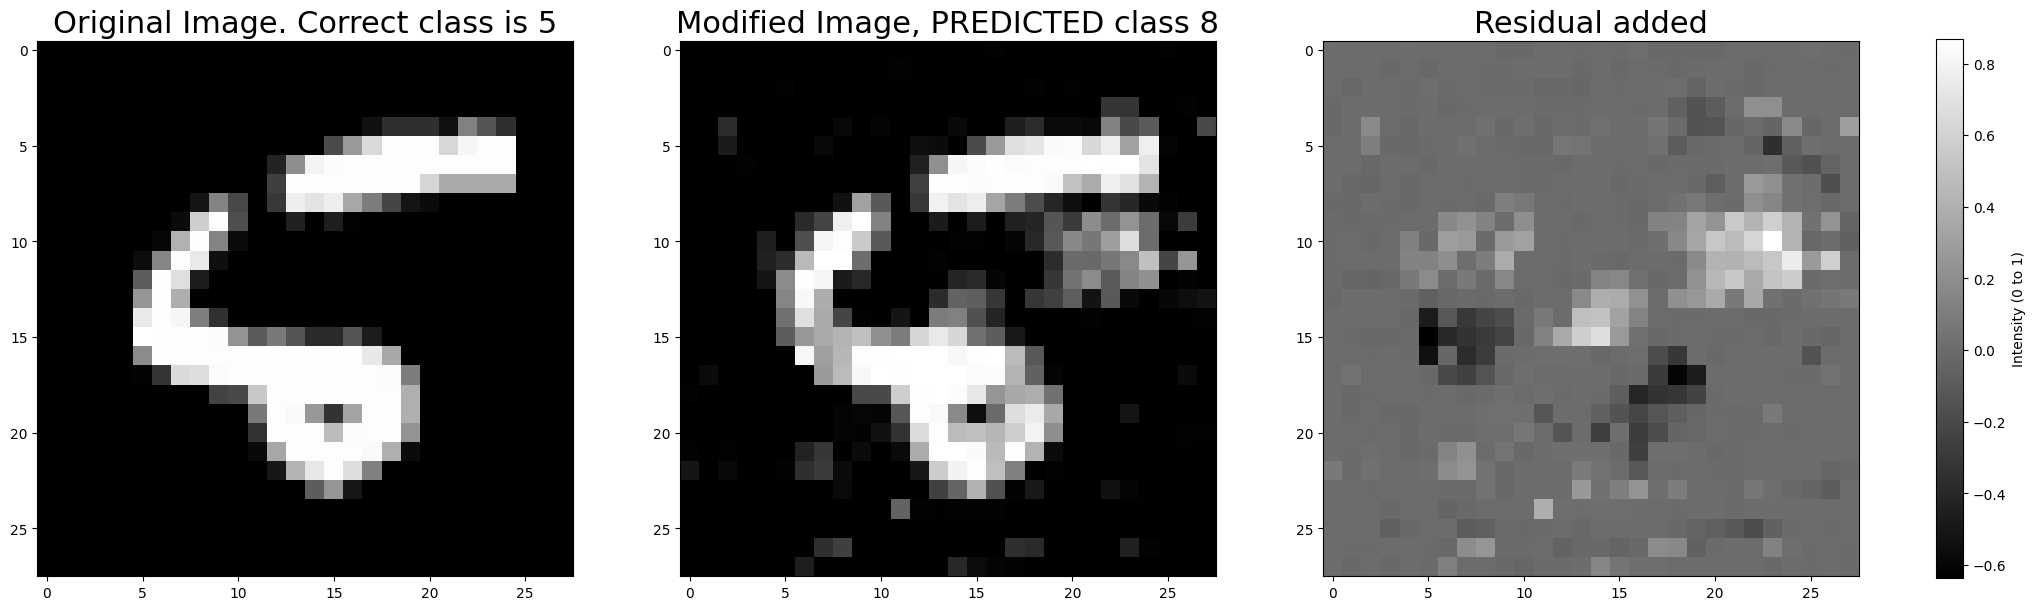

The true class is 6, the new class will be 8
Found c = 0.000100 satisfying f(x + r) = l
Optimization succeeded with c = 0.000100 in 0 iterations
Norm Perturbation |r|: 52.12757873535156


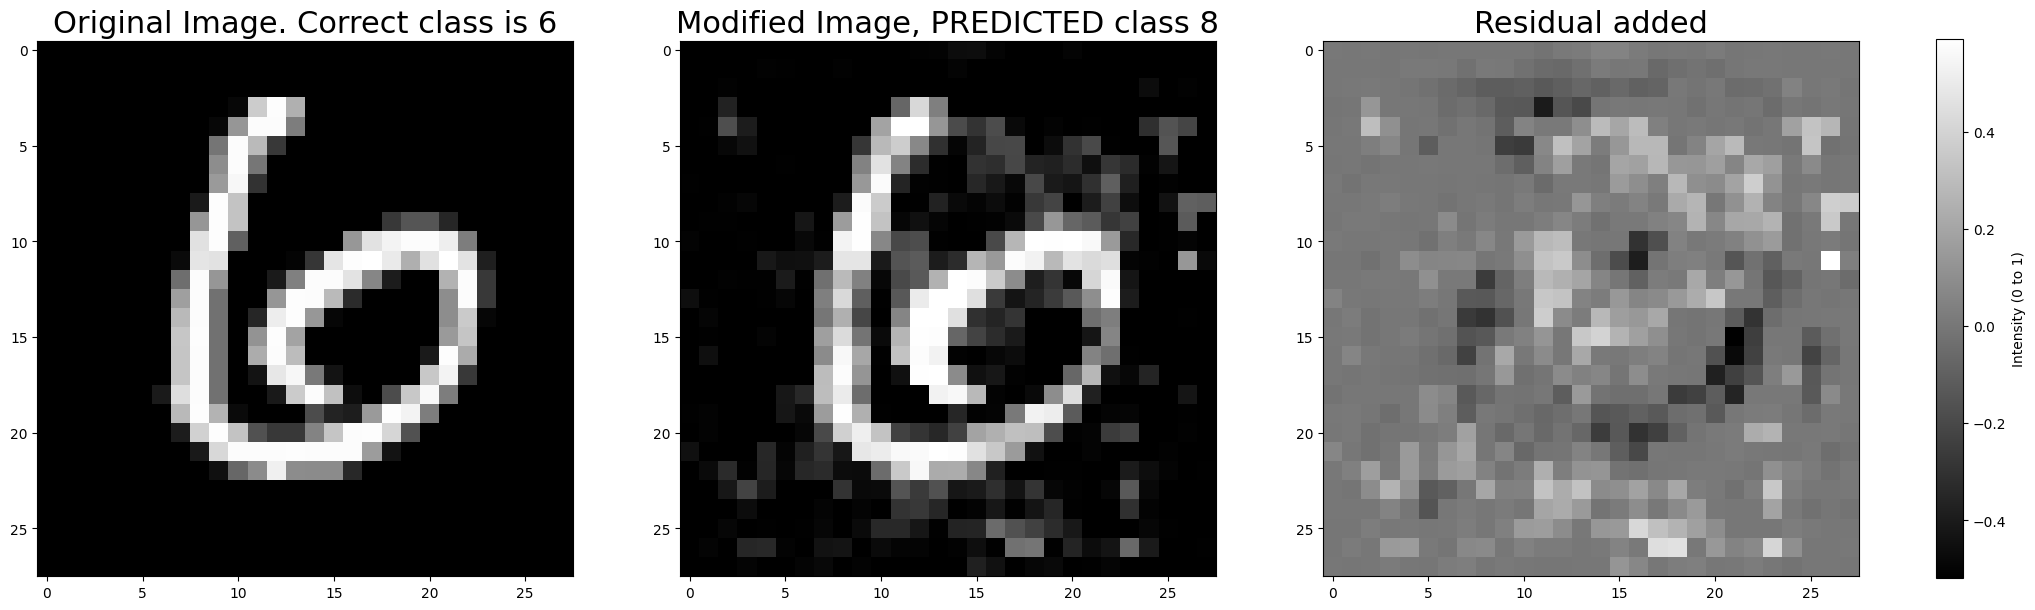

The true class is 7, the new class will be 8
Found c = 0.000100 satisfying f(x + r) = l
Optimization succeeded with c = 0.000100 in 0 iterations
Norm Perturbation |r|: 42.41914367675781


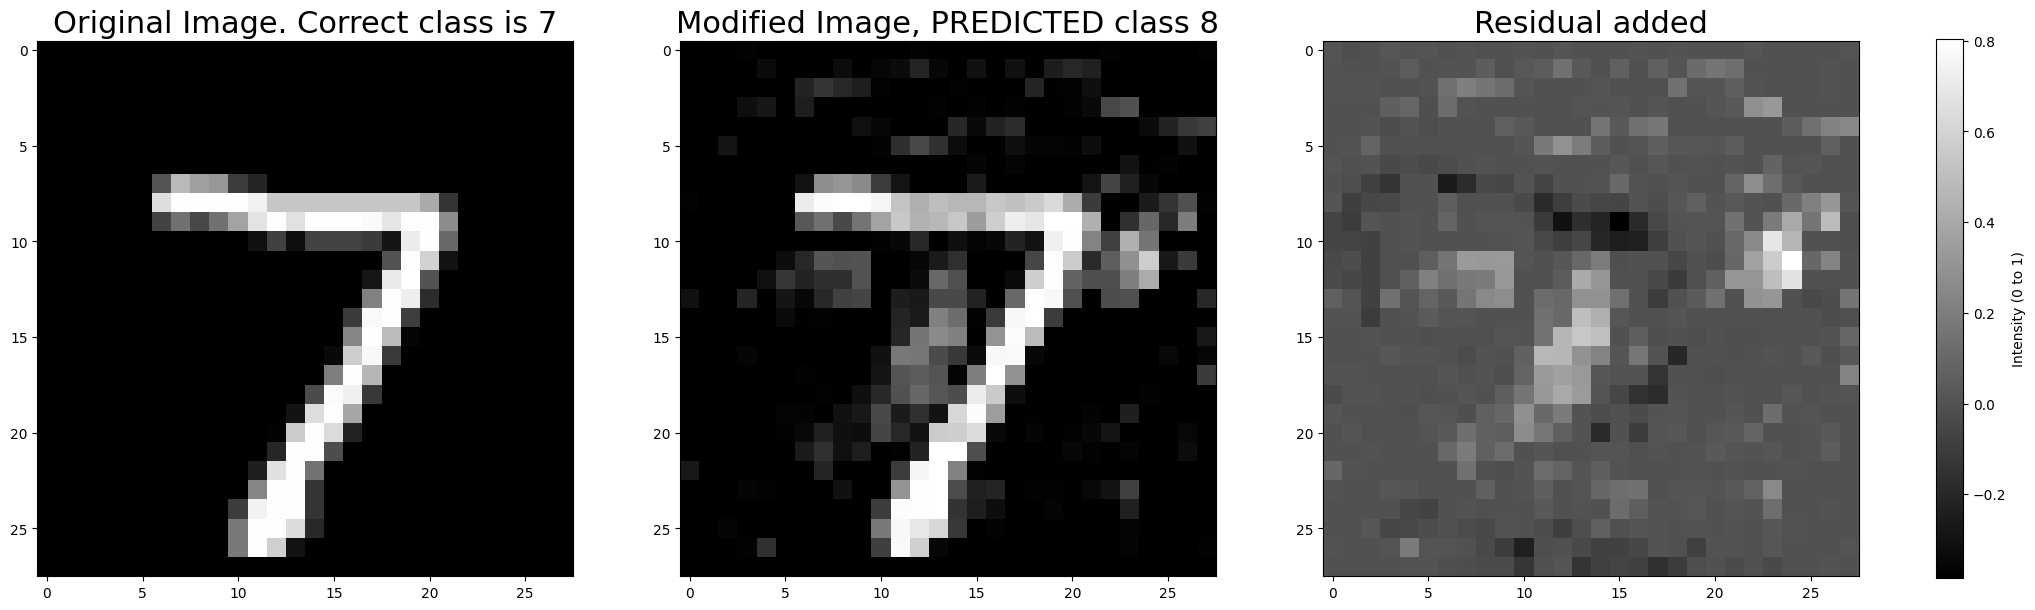

The true class is 8, the new class will be 9
Found c = 0.000100 satisfying f(x + r) = l
Optimization succeeded with c = 0.000100 in 0 iterations
Norm Perturbation |r|: 36.535682678222656


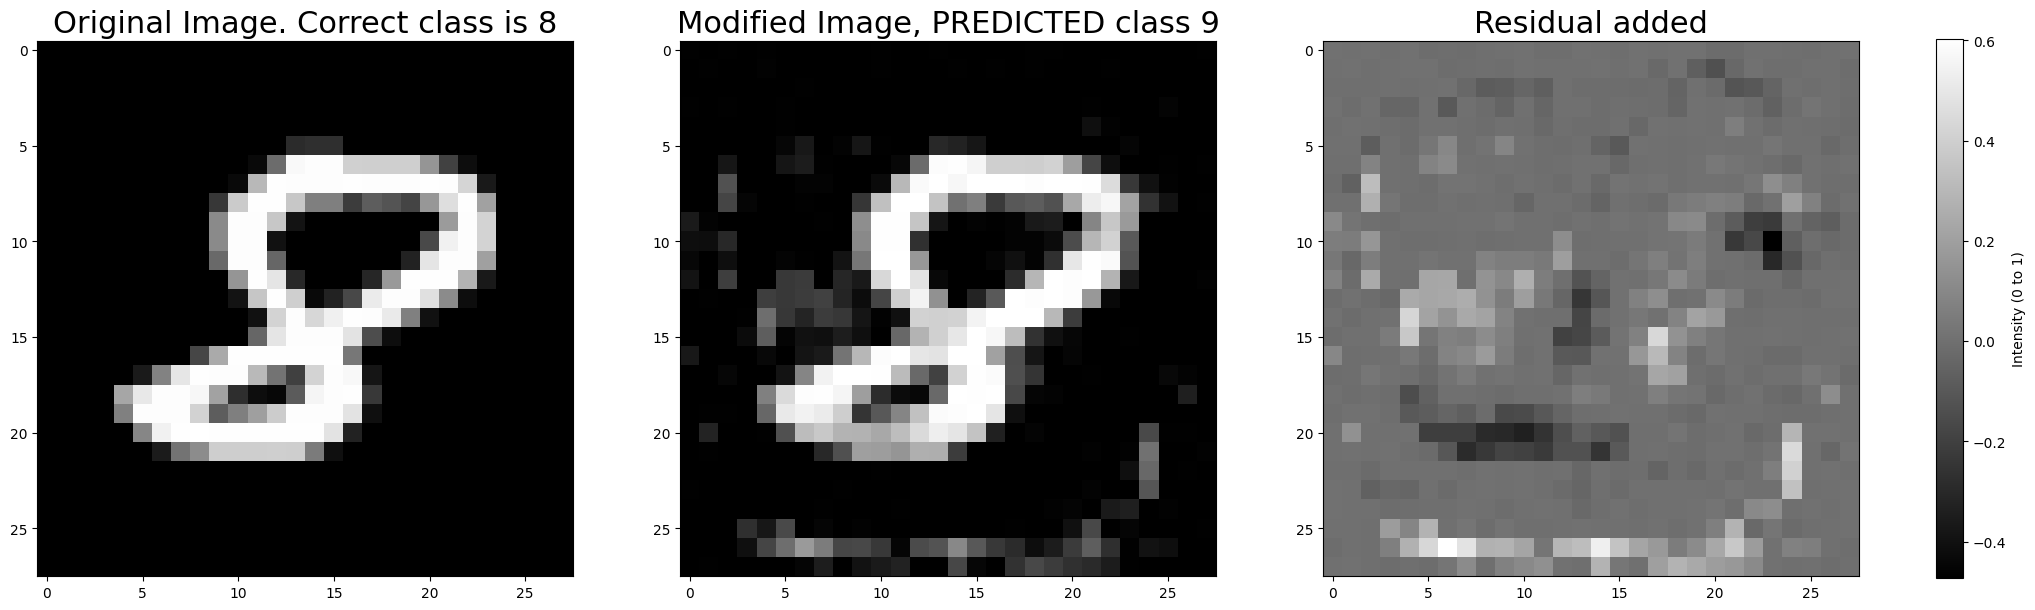

The true class is 9, the new class will be 8
Found c = 0.000100 satisfying f(x + r) = l
Optimization succeeded with c = 0.000100 in 0 iterations
Norm Perturbation |r|: 50.22823715209961


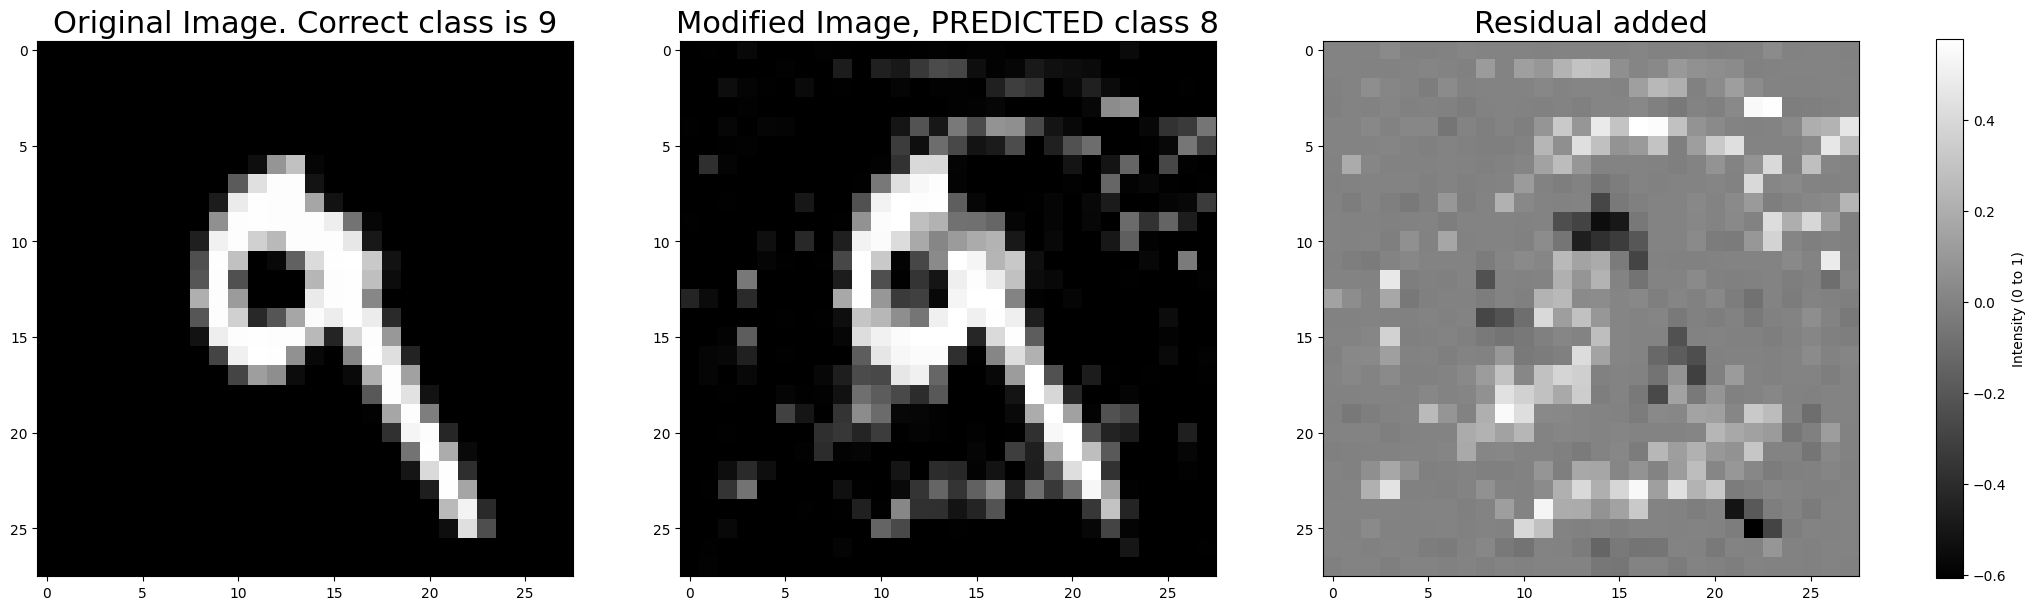

In [18]:
label = 8

for index in index_first_image:
    testI, testY = mnist_test.__getitem__(index)
    label_ = label if testY != label else (label + 1) % 10 # If the image is of the class label, we choose the next class
    _ = adversarial(testI, testY, label_, model, loss_model, device, verbose = True)

**Answer**:

The results are similar to the previous ones (alteration is visible, but a human being would not change their classification; the norm of $r$ is essentially similar).

Next, we use the adversarial images previously created using the first model, and predict the corresponding labels using the second model.

In [19]:
for (adv, testY, label) in list_adversarial:
    # classify using the model_2
    adv = adv.to(device)
    pred = model_2(adv)
    predicted_label = torch.argmax(pred, dim=1)

    print(f"True class: {testY}, Predictive class (model 1): {label}, Predicted class (model 2): {predicted_label.item()}")

True class: 0, Predictive class (model 1): 8, Predicted class (model 2): 8
True class: 1, Predictive class (model 1): 8, Predicted class (model 2): 8
True class: 2, Predictive class (model 1): 8, Predicted class (model 2): 8
True class: 3, Predictive class (model 1): 8, Predicted class (model 2): 8
True class: 4, Predictive class (model 1): 8, Predicted class (model 2): 8
True class: 5, Predictive class (model 1): 8, Predicted class (model 2): 8
True class: 6, Predictive class (model 1): 8, Predicted class (model 2): 8
True class: 7, Predictive class (model 1): 8, Predicted class (model 2): 8
True class: 8, Predictive class (model 1): 9, Predicted class (model 2): 9
True class: 9, Predictive class (model 1): 8, Predicted class (model 2): 8


**Answer**: We see that the predictions of the second model are the ones given by the first model (that is, the label we asked for when creating the adversarial images).

We could have thought that the adversarial images were specific to the first model, and that the noise that was added was specific to this model. However, since the second model predicts the same results, this is not the case.

As said in the abstract of [1], "In addition, the specific nature of these perturbations is not a random artifact of learning: the same perturbation can cause a different network,  that was trained on a different subset of the dataset, to misclassify the same input".

Instead than using L-BFGS to find adversarial examples we could also use a backpropagation method such as Adam, where you could optimize only r or both r and c. 

**Question** Change the previous code to use Adam instead than L-BFGS for the optimization. This means that you don't do anymore a line-search to find the minimum $c$ (no more closure). You can either fix $c$ and estimate only $r$ or estimate both. Try these two solutions and comment on that. Does it work properly ? If not, try to change the loss function. Would you add a regularization term ? If yes, which one and why ? Does it work better ? Please comment on that.

In [20]:
def adversarial_Adam(testI, testY, label, c, c_fixed, model, loss_model, device, verbose = True, reg_neighbor = False, reg_binary = False):
    """
    c_fixed: if True, c is fixed and not optimized, otherwise c is optimized
    reg_neighbor: if True, add a regularization term to the loss function to penalize neighboring pixels (see later)
    reg_binary: if True, add a regularization term to the loss function to penalize binary values (see later)
    """
    testI = testI.to(device)

    r = torch.zeros_like(testI, requires_grad = True, device = device)  # Initialize r as zero
    l = torch.tensor([label]).to(device)  
    l = l.view(1) # to have a batch size equal to 1 and work with CrossEntropy loss
    if verbose:
        print(f"The true class is {testY}, the new class will be {l[0]}")

    # Define the loss function
    def objective(c, r, x, l):
        # Compute the loss function
        y = torch.clamp(x + r, 0, 1)
        loss = loss_model(model(torch.clamp(x + r, 0, 1)), l) + c * torch.norm(x - torch.clamp(x + r, 0, 1), p = 1)

        # Add some regularization
        if reg_neighbor:
            loss += 0.1 * torch.norm(y[:, 1:, :] - y[:, :-1, :], p = 1)
            loss += 0.1 * torch.norm(y[:, :, 1:] - y[:, :, :-1], p = 1)
        if reg_binary:
            loss += 0.1 * torch.minimum(y, 1 - y).sum()
        return loss

    iter = 0

    if not c_fixed:
        c = torch.tensor([c], requires_grad = True, device = device)
    
    lr = 5e-4
    if c_fixed:
        optimizer = optim.Adam([r], lr = lr)
    else:
        optimizer = optim.Adam([r, c], lr = lr)

    # max_iter_search = 500
    while iter <= max_iter_search:    

        # Perform optimization
        optimizer.zero_grad()
        loss = objective(c, r, testI, l)
        loss.backward()
        optimizer.step()

        # Evaluate the condition f(x + r) = l
        with torch.no_grad():
            x_r = torch.clamp(testI + r, 0, 1)  # Ensure x + r ∈ [0, 1]^m
            if not c_fixed:
                c.data = torch.clamp(c.data, 0, max_c)
            pred = model(x_r)
            predicted_label = torch.argmax(pred, dim=1)

        # Check if the condition f(x + r) = l is satisfied
        if predicted_label == l:
            break

        iter=iter+1
    
    if (iter > max_iter_search):
        if verbose:
            print("Failed to find c satisfying f(x + r) = l within the maximum number of iter.")
            if not c_fixed:
                print(f"Optimal c found: {c.item()}")
        plot_results(testI, r, x_r, testY, l, fail=True)
    
    else:
        if verbose:
            print(f"Optimization succeeded")
            print(f"Norm Perturbation |r|: {torch.norm(r, p=1)}")
            if not c_fixed:
                print(f"Optimal c found: {c.item()}")
        plot_results(testI, r, x_r, testY, l, fail=False)
    
    return x_r

**Answer**: First, we compare when $c$ is fixed, then when $c$ is not fixed.

The true class is 9, the new class will be 1


Optimization succeeded
Norm Perturbation |r|: 23.636516571044922


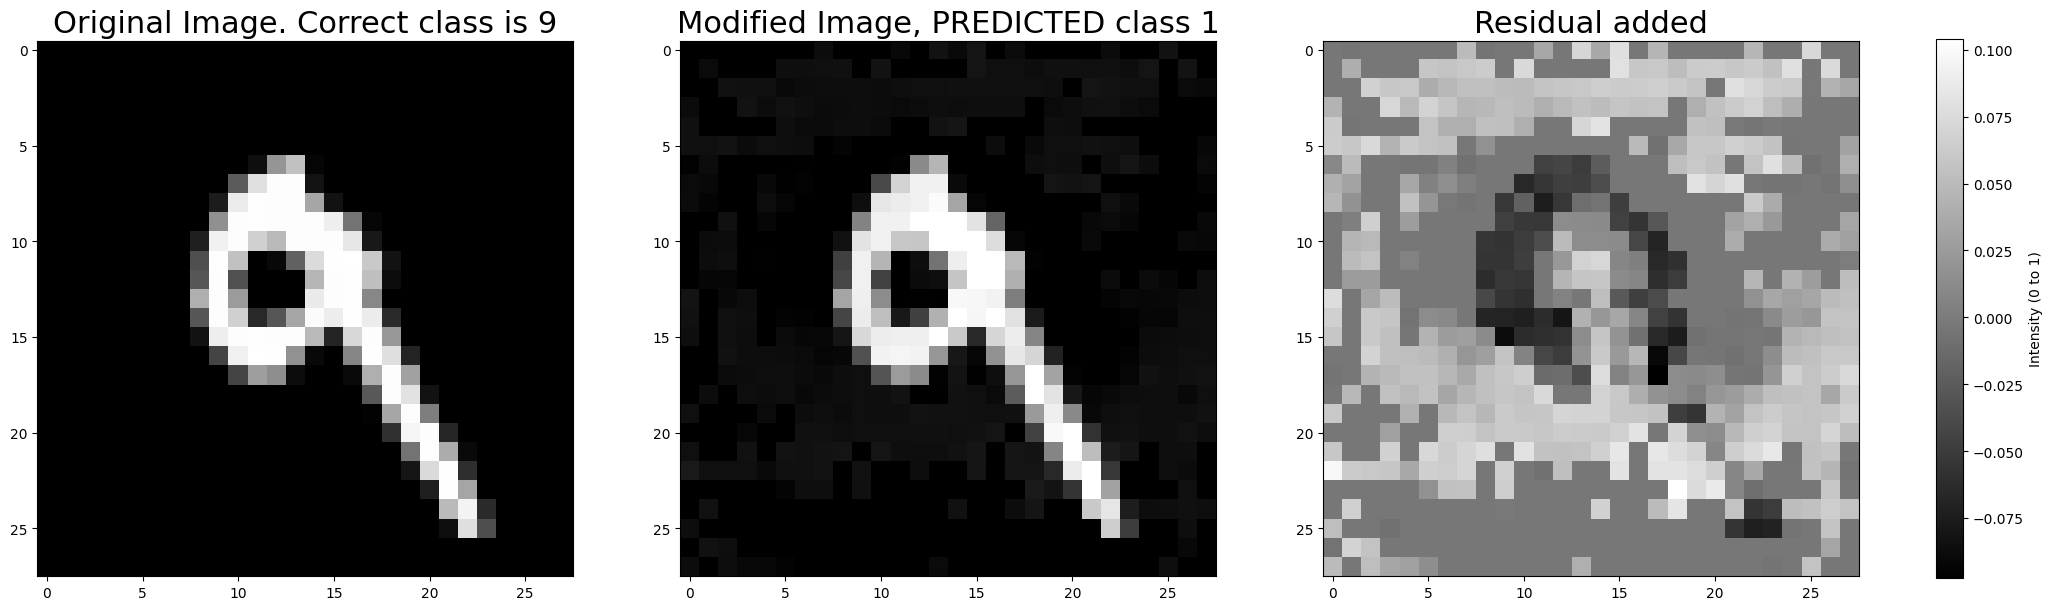

In [21]:
# Fixed c

adv = adversarial_Adam(testI, testY, 1, initial_c, True, model, loss_model, device, verbose = True)

The true class is 9, the new class will be 1
Optimization succeeded
Norm Perturbation |r|: 23.643281936645508
Optimal c found: 0.0


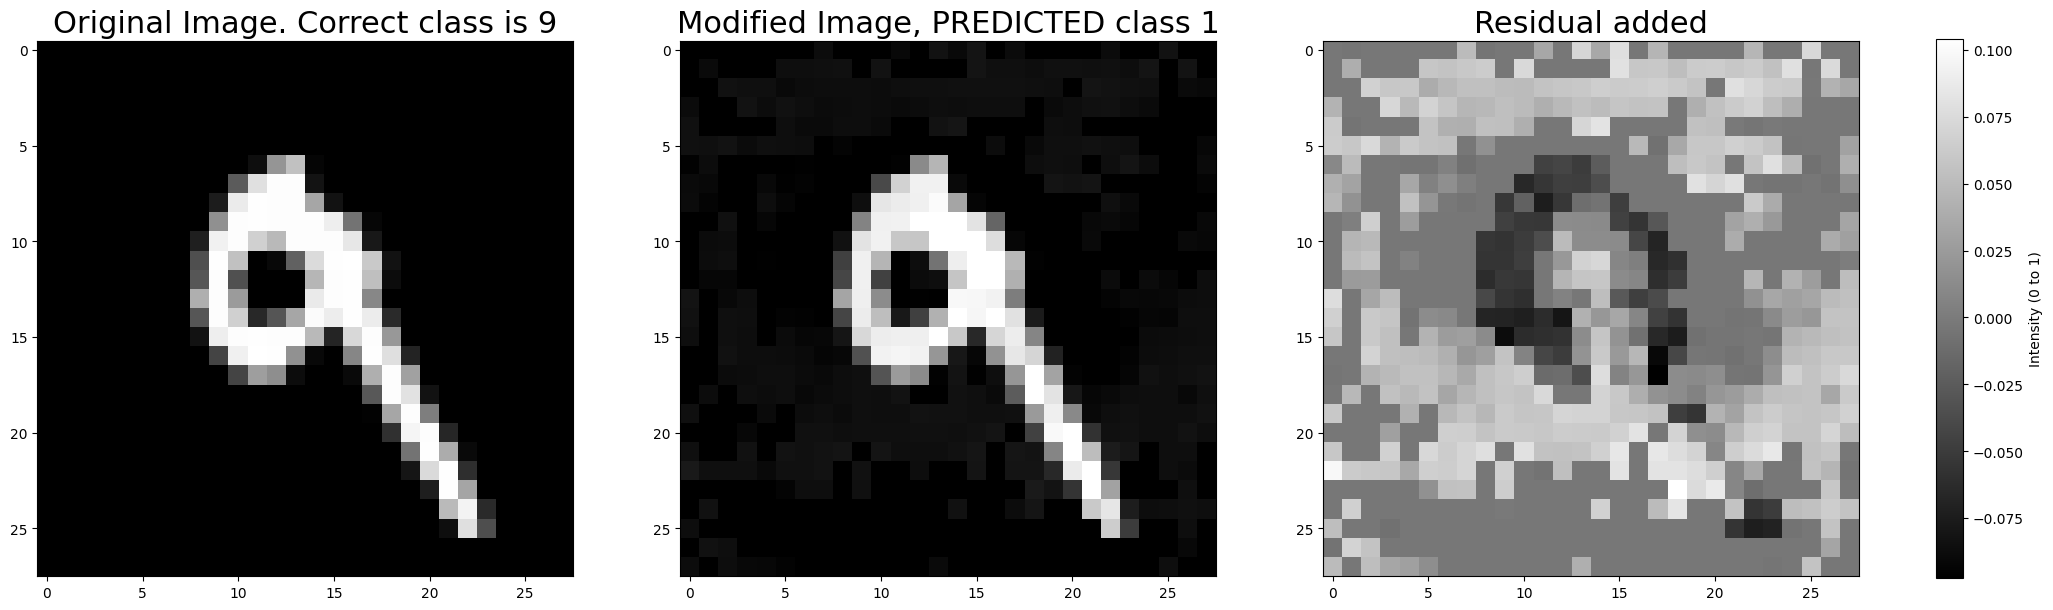

In [22]:
# Optimized c
adv = adversarial_Adam(testI, testY, 1, initial_c, False, model, loss_model, device, verbose = True)

**Answer**: we see that we get very similar results for fixed $c$ and optimized $c$. We also see that the noise is different on the pixels corresponding to the written digit and on the pixels corresponding to the background. We get a rather low value for the perturbation $r$.

However, we observe artifacts in the background. We can think of at least two regularizations: one where we penalize neighboring pixels which do not have the same colour, and one where we penalize pixels whose values are far from 0 and 1.

We look at the effect of each regularization, and the two combined.

The true class is 9, the new class will be 1
Optimization succeeded
Norm Perturbation |r|: 21.884695053100586


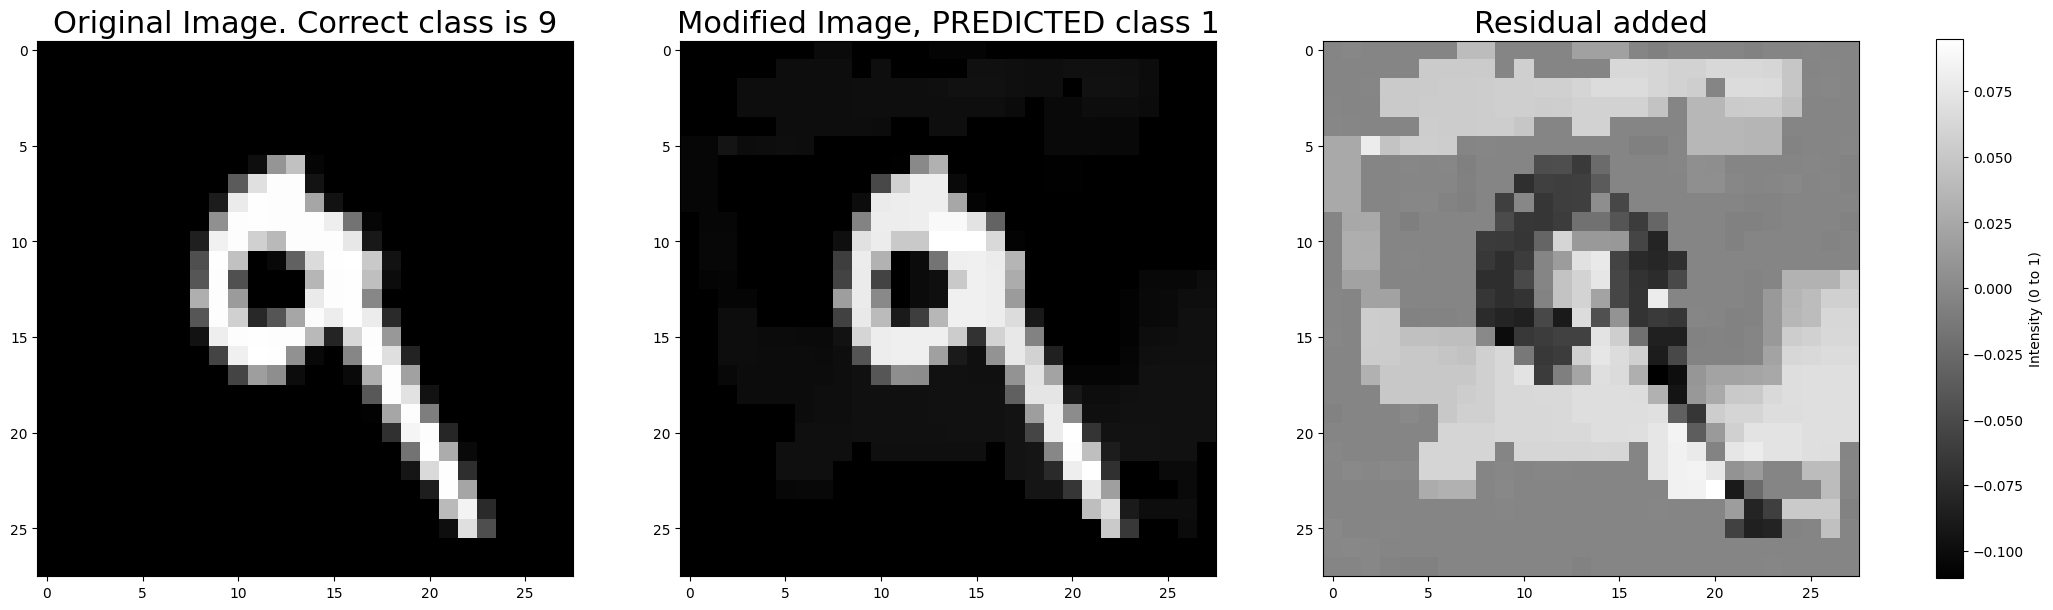

In [23]:
# Neighboring pixels regularization
_ = adversarial_Adam(testI, testY, 1, initial_c, True, model, loss_model, device, verbose = True, reg_neighbor = True, reg_binary = False)

The true class is 9, the new class will be 1
Optimization succeeded
Norm Perturbation |r|: 19.564159393310547


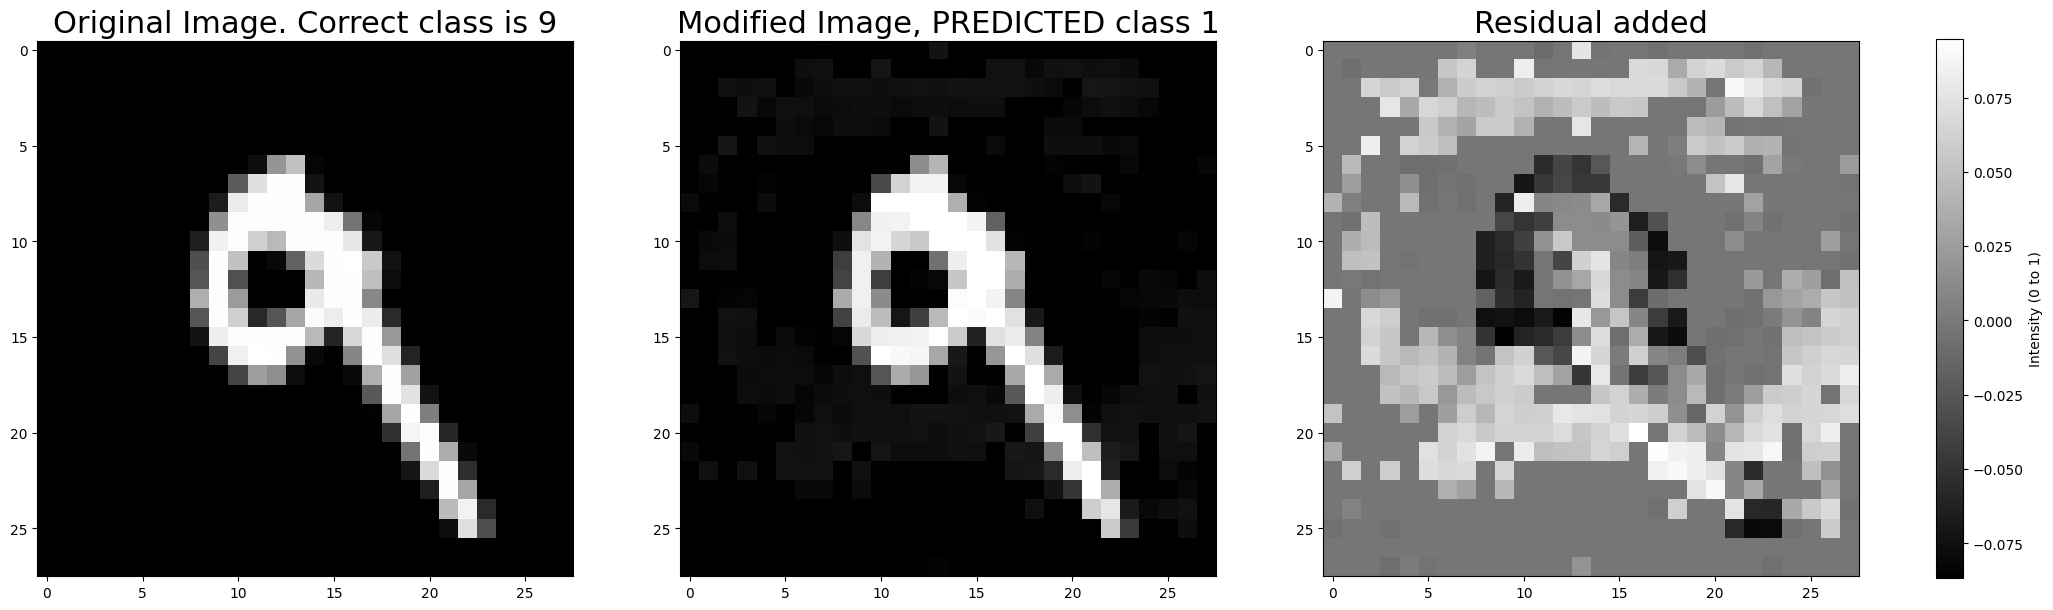

In [24]:
# Binary values regularization
_ = adversarial_Adam(testI, testY, 1, initial_c, True, model, loss_model, device, verbose = True, reg_neighbor = False, reg_binary = True)

The true class is 9, the new class will be 1
Optimization succeeded
Norm Perturbation |r|: 19.47150421142578
Optimal c found: 0.0


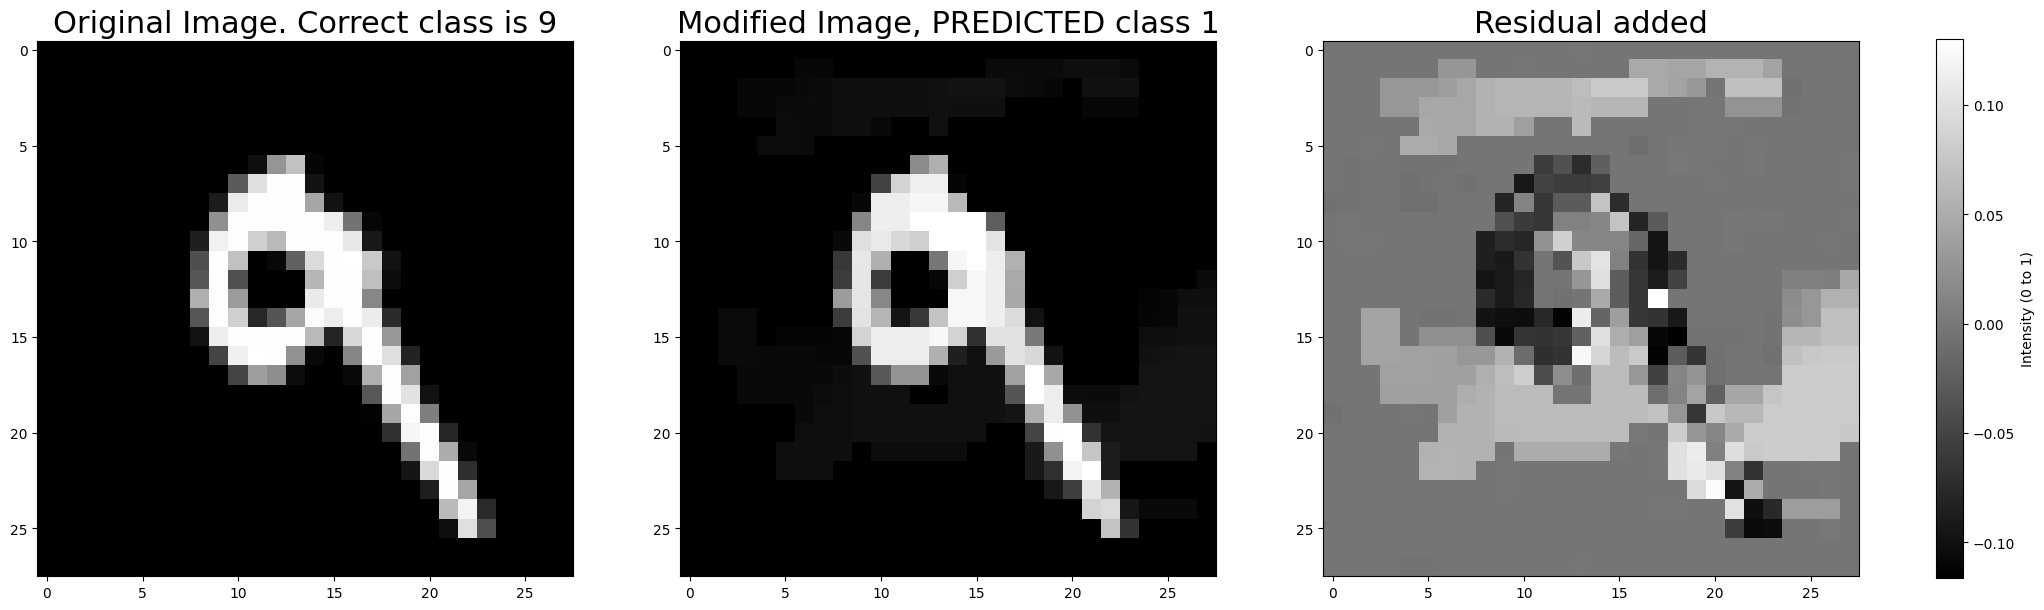

In [25]:
# Both regularizations
_ = adversarial_Adam(testI, testY, 1, initial_c, False, model, loss_model, device, verbose = True, reg_neighbor = True, reg_binary = True)

**Answer**: using only the neighboring pixel penalization reduces the norm of the perturbation; using only the regularization for pixels with values far from 0 and 1 leads to a much smaller perturbation; using the two penalizations leads to an even smaller perturbation. Visually, using the two regularizations indeed leads to a darker (more homogeneous) background, though some artifacts remain.

# Fast Gradient Sign Attack (FGSM)

Another famous method to create adversarial examples is Fast Gradient Sign Attack (FGSM). Let $\theta$ be the parameters of a model, x the input image to the model, y its class and J(θ, x, y) the cost used to train the neural network. Usually, when training a model, we compute the gradient of the cost function with respect to the parameters of the model and update them based on the oppositve (i.e., negative) direction of the gradient to decrease the loss. Here, we can replicate the same reasoning but using the pixel values of the input image instead than the model's parameters and using the gradient direction (i.e., positve) to actually maximize the loss. The idea is thus to modify the pixel values so that the loss is maximized and not minimized. In this way, the perturbation should change the image so that it will be misclassified by the model. In order to keep the changes small, possibly imperceptible to naked eye, we only use the sign of the gradient and multiply it by a small $\epsilon$ value. Mathematically, the adversarial example is estimated using:
 $$x_r =x + \epsilon \text{sign}(\Delta_x J(\theta, x, y))$$

 The gradient can easily be computed using backpropagation (Adam).


[*]` Ian J. Goodfellow, Jonathon Shlens & Christian Szegedy Explaining and harnessing adversarial examples. ICLR. 2015`

Let's load an image.

In [26]:
# Parameters
index=20
testI, testY = mnist_test.__getitem__(index)
X = testI.unsqueeze(0).to(device)
print(X.shape)
X.requires_grad = True # Important for attack
Y=torch.tensor([testY]).to(device)

torch.Size([1, 1, 28, 28])


And plot it.

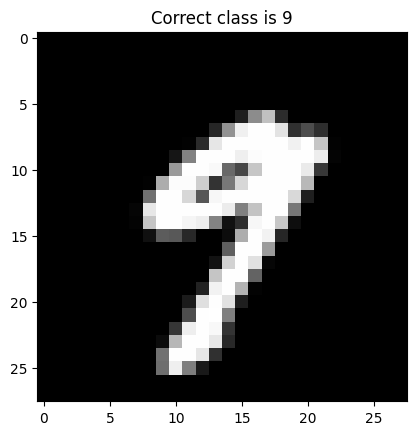

In [27]:
fig = plt.imshow(testI.squeeze(), interpolation='nearest', cmap=plt.cm.gray)
plt.title(f"Correct class is {testY}")
plt.show()

Complete the code by fixing a `eps`value.

Original Class: 9, Perturbed Class: 7
Optimization succesfull
Norm Perturbation |r|: 109.76000213623047


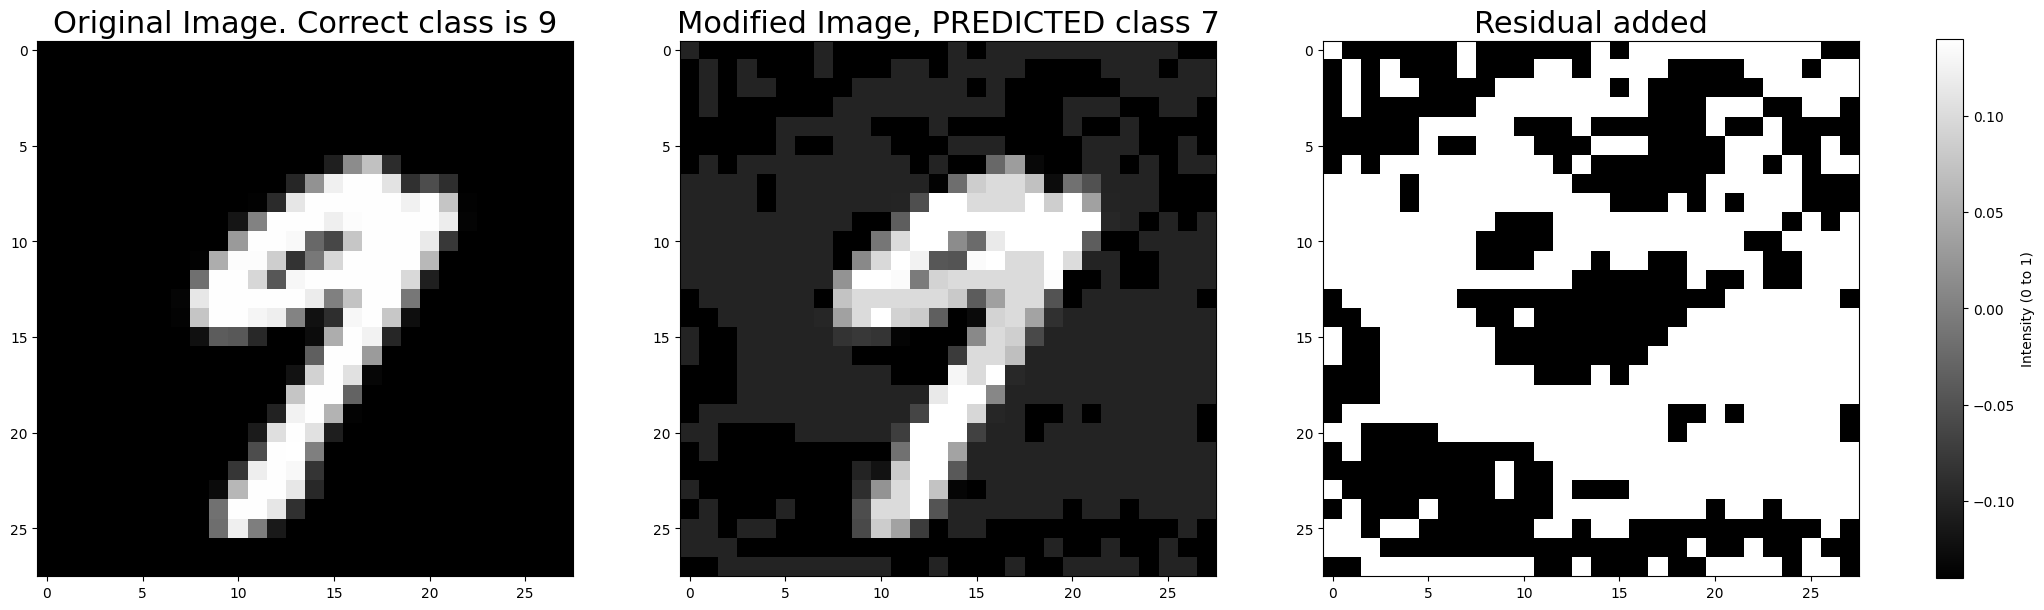

In [28]:
# fast gradient sign attack

eps = 0.14 # perturbation size

# Forward pass of X through the model
pred_original = model(X)  
original_class= torch.argmax(pred_original, dim=1) # predicted class before perturbation

# Compute loss
cost = loss_model(pred_original, Y)

# Zero existing (previous) gradients
model.zero_grad()

# Compute gradients
cost.backward()

# FGSM attack code
Xr = X + eps * X.grad.data.sign() # perturbed image
Xr = torch.clamp(Xr, 0, 1)

# Re-classify the perturbed image
pred_perturbed = model(Xr)
perturbed_class= torch.argmax(pred_perturbed, dim=1) # predicted class after perturbation    

# Print results
print(f"Original Class: {original_class.item()}, Perturbed Class: {perturbed_class.item()}")

r=eps*X.grad.data.sign()

if original_class.item()==perturbed_class.item():
    print(f"Optimization failed")
    print(f"Norm Perturbation |r|: {torch.norm(r, p=1)}")
    plot_results(X, r, Xr, testY, perturbed_class, fail=True)   
else:
    print(f"Optimization succesfull")
    print(f"Norm Perturbation |r|: {torch.norm(r, p=1)}")
    plot_results(X, r, Xr, testY, perturbed_class, fail=False)

Now, to find the best `eps`value, you will code a function and evalute the successful rate for each `eps`value (number of images where an adversarial examples has been successfully created). 

**Question**: What's the best `eps`value ? Are the changes imperceptible to a naked human eye ?

Original Class: 9, Perturbed Class: 7
Norm Perturbation |r|: 54.880001068115234
epsilon: 0.07


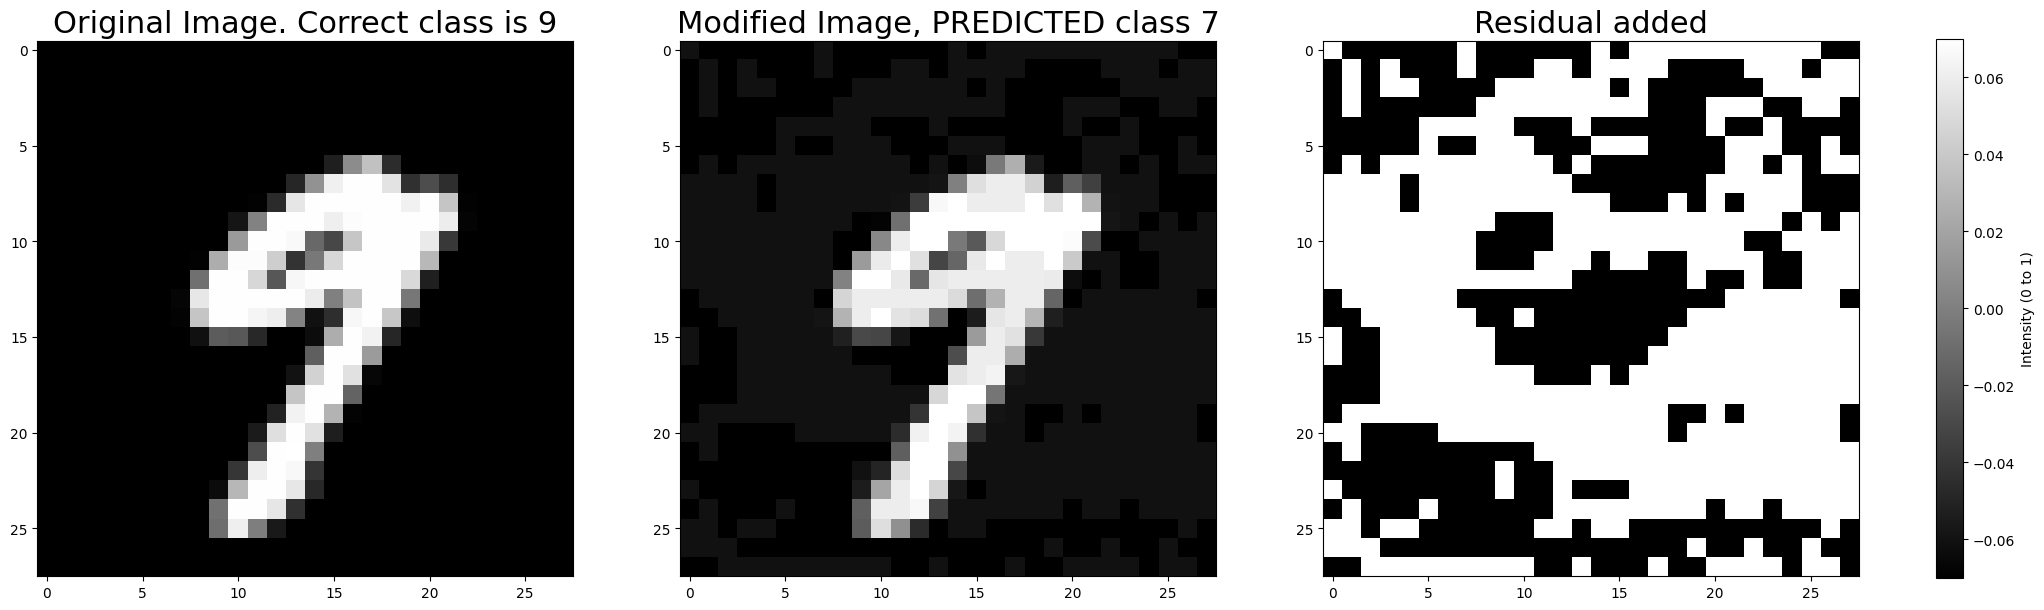

Using epsilon = 0.07 we successfully create 54.76 % adversarial examples, with an average perturbation norm of 34.78.

Original Class: 9, Perturbed Class: 7
Norm Perturbation |r|: 62.720001220703125
epsilon: 0.08


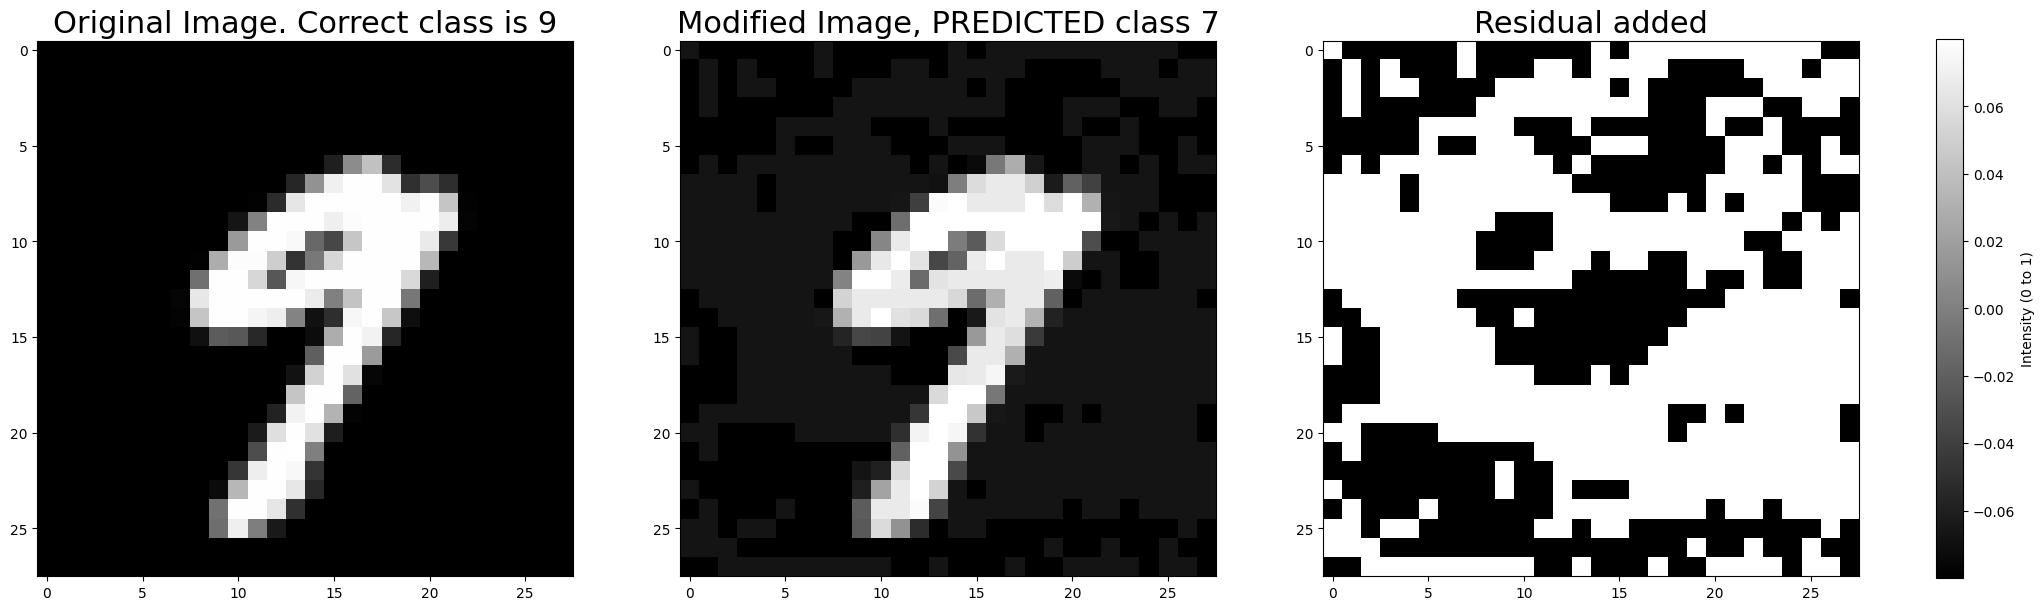

Using epsilon = 0.08 we successfully create 63.81 % adversarial examples, with an average perturbation norm of 39.68.

Original Class: 9, Perturbed Class: 7
Norm Perturbation |r|: 70.55999755859375
epsilon: 0.09


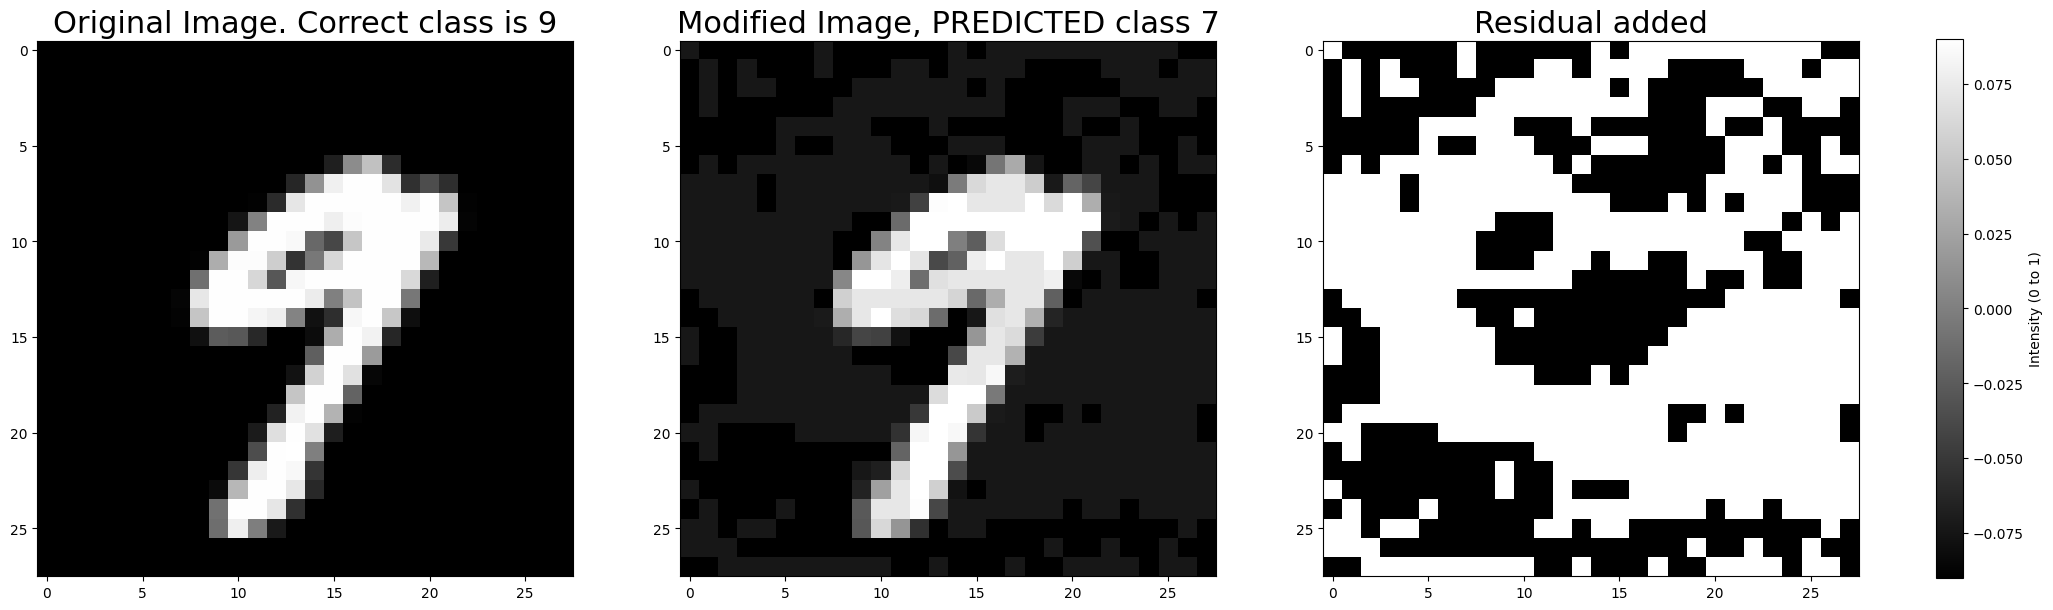

Using epsilon = 0.09 we successfully create 71.10 % adversarial examples, with an average perturbation norm of 44.56.

Original Class: 9, Perturbed Class: 7
Norm Perturbation |r|: 78.4000015258789
epsilon: 0.1


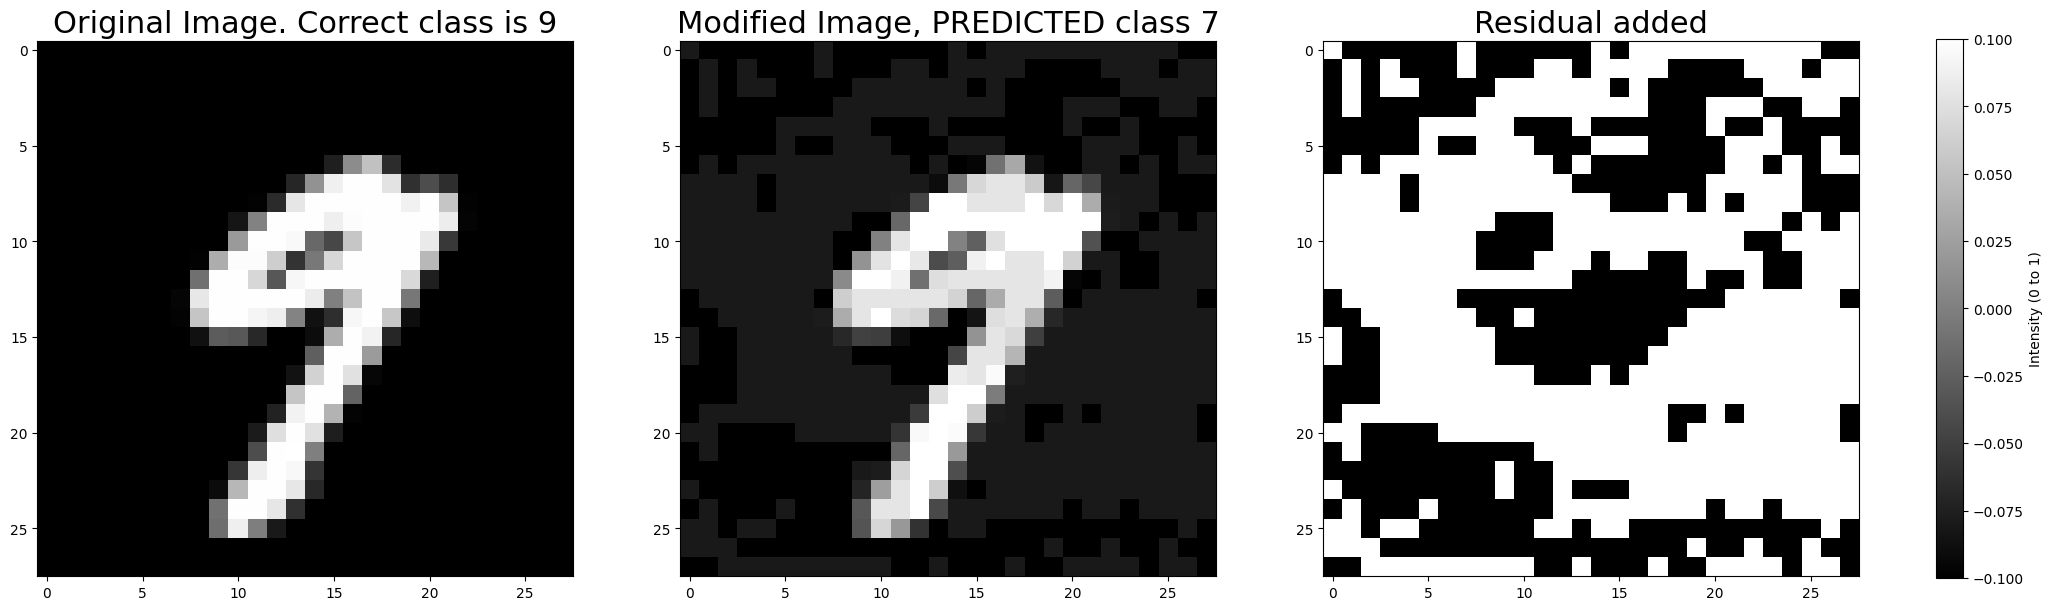

Using epsilon = 0.1 we successfully create 77.22 % adversarial examples, with an average perturbation norm of 49.44.

Original Class: 9, Perturbed Class: 7
Norm Perturbation |r|: 86.23999786376953
epsilon: 0.11


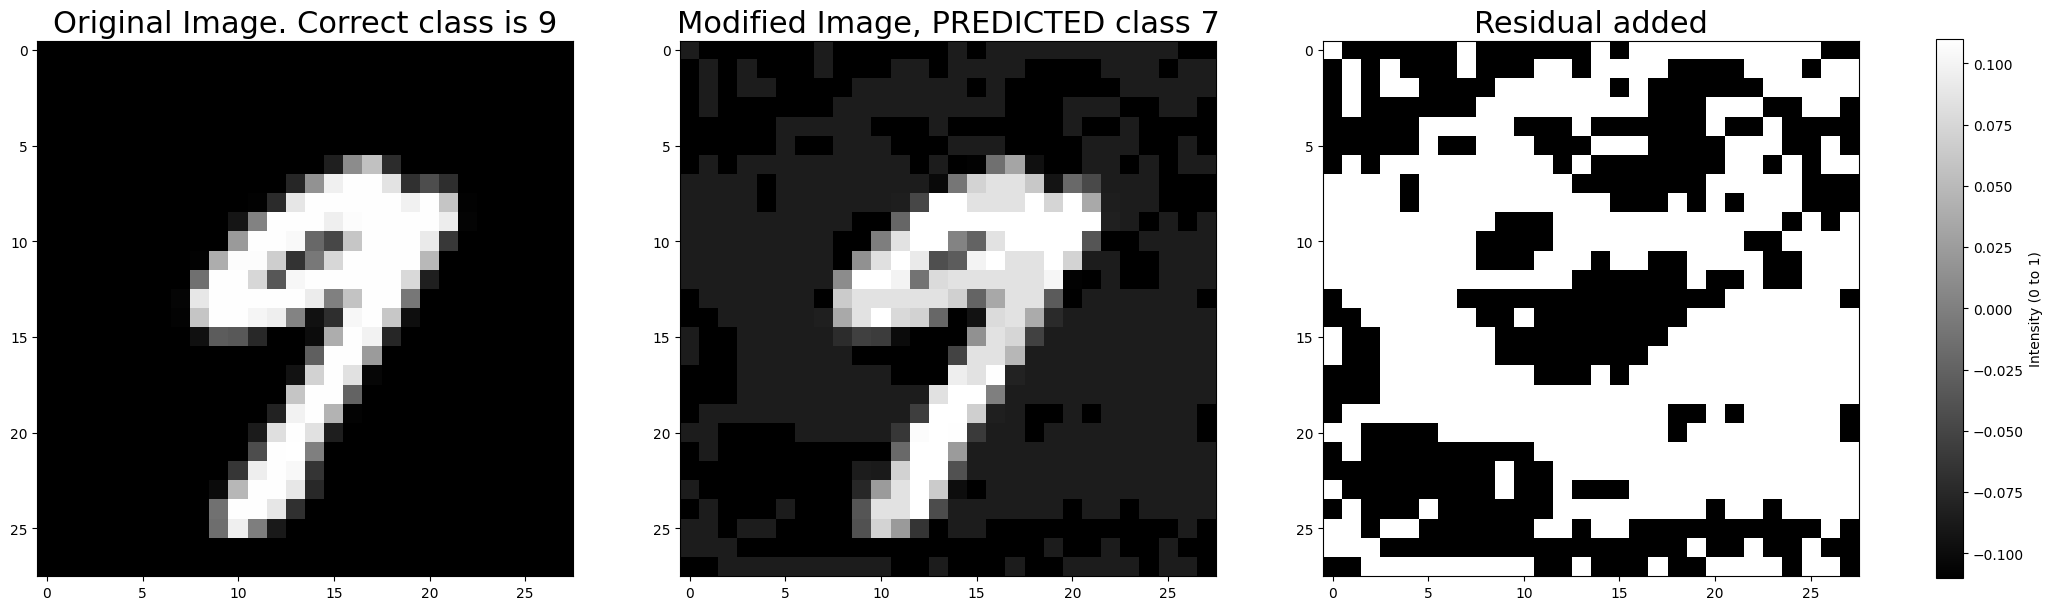

Using epsilon = 0.11 we successfully create 81.57 % adversarial examples, with an average perturbation norm of 54.30.

Original Class: 9, Perturbed Class: 7
Norm Perturbation |r|: 94.08000183105469
epsilon: 0.12


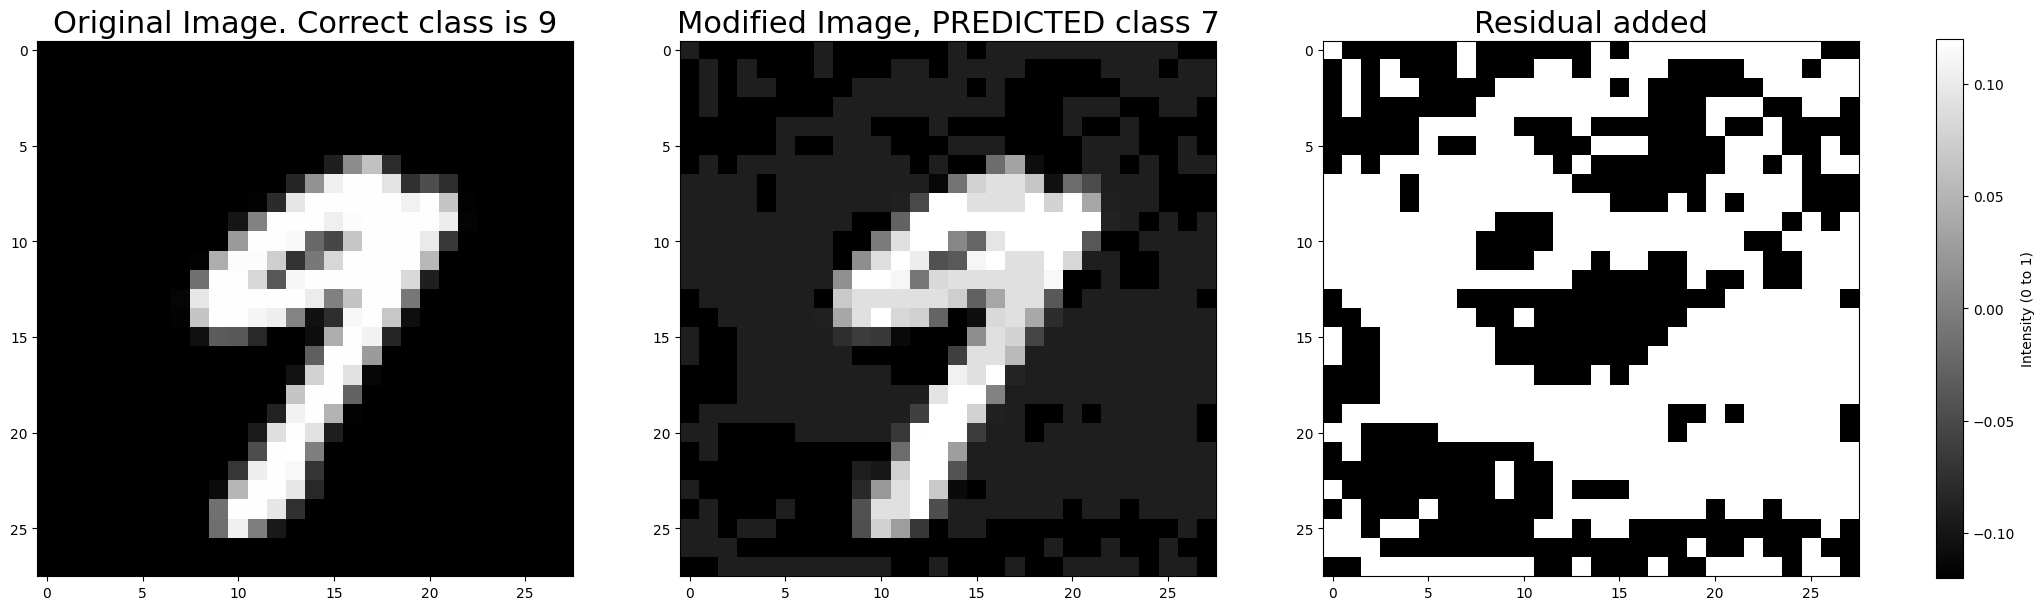

Using epsilon = 0.12 we successfully create 85.46 % adversarial examples, with an average perturbation norm of 59.16.



In [29]:
def fgsm_attack(X, Y, model, loss_model, eps):
    """
    Fast Gradient Sign Attack
    """

    pred_original = model(X)
    original_class = torch.argmax(pred_original, dim=1)

    cost = loss_model(pred_original, Y.unsqueeze(0))
    model.zero_grad()

    cost.backward()

    Xr = X + eps*X.grad.data.sign()
    Xr = torch.clamp(Xr, 0, 1)

    pred_perturbed = model(Xr)
    perturbed_class = torch.argmax(pred_perturbed, dim=1)

    r = eps*X.grad.data.sign()

    return Xr, original_class, perturbed_class, r

results = []

# Test the FGSM attack for different values of epsilon
for eps in [0.07, 0.08, 0.09, 0.1, 0.11, 0.12]:
    # Accuracy counter
    adv_examples = []
    success = 0
    total_norm = 0
    total = 0

    # Loop over all examples in test set
    for X_batch, Y_batch in test_loader:
        for i, (X, Y) in enumerate(zip(X_batch, Y_batch)):
            X = X.to(device)
            Y = Y.to(device)
            X.requires_grad = True

            # Call Fast Gradient Sign Attack
            Xr, original_class, perturbed_class, r = fgsm_attack(X, Y, model, loss_model, eps)
            total_norm += torch.norm(X - Xr, p = 1).item()

            # Check for success
            if original_class.item() == perturbed_class.item():
                adv_ex = Xr.squeeze().detach().cpu().numpy()
                adv_examples.append((X, Xr, Y, original_class, perturbed_class, r))
                if i == index:
                    print(f"Original Class: {original_class.item()}, Perturbed Class: {perturbed_class.item()}")
                    print(f"Norm Perturbation |r|: {torch.norm(r, p=1)}")
                    print(f"epsilon: {eps}")
                    plot_results(X, r, Xr, Y, perturbed_class, fail=True)
            else:
                success += 1
                if i == index:
                    print(f"Original Class: {original_class.item()}, Perturbed Class: {perturbed_class.item()}")
                    print(f"Norm Perturbation |r|: {torch.norm(r, p=1)}")
                    print(f"epsilon: {eps}")
                    plot_results(X, r, Xr, Y, perturbed_class, fail=False)
            total += 1
        

    # Calculate final accuracy for this epsilon
    Adv_acc = (success / total) * 100
    norm = total_norm / total

    results.append((eps, Adv_acc, norm))
    print(f"Using epsilon = {eps} we successfully create {Adv_acc:.2f} % adversarial examples, with an average perturbation norm of {norm:.2f}.\n")

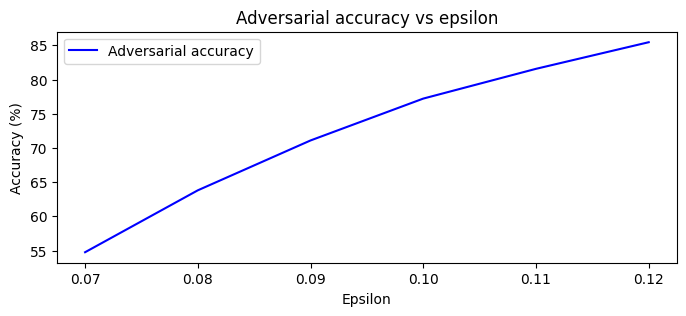

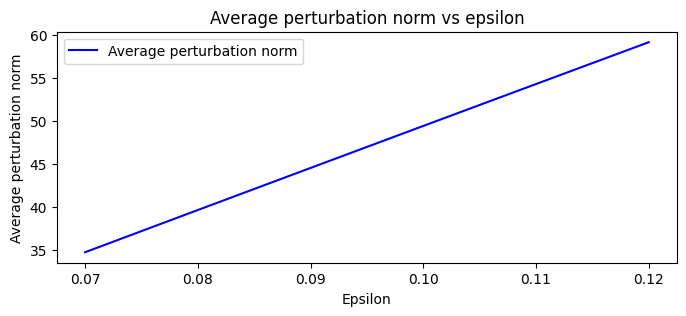

In [30]:
# Plot results
plt.figure(figsize = (8, 3))
plt.plot([r[0] for r in results], [r[1] for r in results], 'b', label='Adversarial accuracy')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy (%)')
plt.title('Adversarial accuracy vs epsilon')
plt.legend()
plt.show()

plt.figure(figsize = (8, 3))
plt.plot([r[0] for r in results], [r[2] for r in results], 'b', label='Average perturbation norm')
plt.xlabel('Epsilon')
plt.ylabel('Average perturbation norm')
plt.title('Average perturbation norm vs epsilon')
plt.legend()
plt.show()

**Answer**: We see that the algorithm works, even though not always.

- For low values of $\varepsilon$, the average perturbation norm is rather small, but the proportion of images correctly misclassified is small as well. This makes sense: for low $\epsilon$, we only slightly change the image, and therefore fail to lead the model to misclassify it.

- For large values of $\varepsilon$, the average perturbation norm increases, and so does the proportion of images correctly misclassified. This time, we allowed the gradient descent to have a large enough step, leading the model to misclassify it.

There is a trade-off here between the adversarial accuracy and the visual result: low epsilon means low accuracy, large epsilon means visually altered images. Indeed, as seen above, we clearly see that the image is altered; though we still know which digit is represented, we see artifacts in the background.